## The required libraries

In [ ]:
#!pip install --target /Users/chiragrathi/anaconda3/lib/python3.10/site-packages/ uncertainties

In [22]:
import pandas as pd 
import numpy as np 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from uncertainties import ufloat, correlated_values, nominal_value, std_dev
import uncertainties.umath as umath
from matplotlib.lines import Line2D

## Models used for fitting

## The Constant Temperature model:

The constant temperature (CT) model is a phenomenological model of describing nuclear level densities (NLDs). It is given by the following equation:

$$ \rho (x,T,E_0) = \frac{1}{T} \exp{\left(\frac{x - E_0}{T}\right)} $$

In the above equation, x is the excitation energy, T is the temperature parameter and $E_0$ is the energy back-shift parameter. The parameters, T and $E_0$ are fitting parameters.

In [15]:
def ctm(x,T,E0):
    return 1/T * np.exp((x-E0)/T)

def u_ctm(x,T,E0):
    return 1/T * umath.exp((x-E0)/T)


## Loading RIPL data

RIPL is an existing database that houses NLD data from neutron resonance technique only. Link to the database: https://www-nds.iaea.org/RIPL-3/

In [3]:
# loading ctm data from RIPL database.
df_ripl_ctm = pd.read_csv('level-densities-ctmeff.dat',header=0,sep='\s+')

## Data Analysis with Evaporation sets

In [4]:
df_main = pd.read_excel('log_book_new.xlsx')

df_datafiles = df_main.dropna(subset=['Datafile'])

df_datafiles.reset_index(inplace=True)


In [5]:
T,E0,cov_mat = np.array([]),np.array([]), []

T_err,E_err = np.array([]),np.array([])


for i in range(len(df_datafiles['Datafile'])):
    
    #print(df_datafiles['Isotope'][i])
    df_datafiles_data_address = df_datafiles['Datafile'].iloc[i]
    #print(df_datafiles_data_address)
    df_datafiles_data = pd.read_csv(df_datafiles_data_address,header=None,comment='#')
    
    
    if len(df_datafiles_data.columns != 3):
        df_datafiles_data[2] = 0.0
    
    df_datafiles_data[2] = df_datafiles_data[2].replace(np.NaN,0.0)

    # apply 20% error if error is listed as 0 or if it is missing
    df_datafiles_data[2] = df_datafiles_data.apply(lambda row: 0.2 * row[1] if row.get(2, 0.0) == 0.0 else row.get(2, 0.0), axis=1)
    
    
    Emin = df_datafiles['Emin'].iloc[i]
    Emax = df_datafiles['Emax'].iloc[i]
    #print(Emin,Emax)
    df_datafiles_fit = df_datafiles_data[(df_datafiles_data[0] >= Emin) & (df_datafiles_data[0] <= Emax)]
    #print(df_datafiles_fit.head())
    #df_datafiles_data[2] = df_datafiles_data.apply(lambda row: 0.2 * row[1] if row[2] == 0.0 else row[2], axis=1)

    popt, pcov = curve_fit(ctm, df_datafiles_fit[0],df_datafiles_fit[1],sigma=df_datafiles_fit[2],
                           absolute_sigma=True)

    
    temp, energy = popt[0],popt[1]
    
    dT, dE = np.sqrt(np.diag(pcov))
    T = np.append(T,temp)
    E0 = np.append(E0,energy)
    
    T_err = np.append(T_err,dT)
    E_err = np.append(E_err,dE)
    cov_mat.append(pcov)
    

df_datafiles['T'] = T
df_datafiles['E0'] = E0
df_datafiles['dT'] = T_err
df_datafiles['dE0'] = E_err


/Users/chiragrathi/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/9d/120xs_y93rbgd7vklz1_82tm0000gn/T/ipykernel_63491/2448740.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_datafiles['T'] = T
/var/folders/9d/120xs_y93rbgd7vklz1_82tm0000gn/T/ipykernel_63491/2448740.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_datafiles['E0'] = E0
/var/folders/9d/120xs_y93rbgd

In [6]:
df_datafiles['Method'].unique()

array(['Ericson', 'Scattering Wavelet', 'Oslo', 'Evaporation',
       'Beta Oslo', 'Inverse Oslo', 'Oslo Shape'], dtype=object)

In [7]:
df_datafiles_cut = df_datafiles.drop(1)

df_datafiles_cut = df_datafiles_cut.reset_index()
df_evap = df_datafiles_cut[df_datafiles_cut['Method'] == 'Evaporation']
df_Oslo = df_datafiles_cut[df_datafiles_cut['Method'] == 'Oslo']
df_betaOslo = df_datafiles_cut[df_datafiles_cut['Method'] == 'Beta Oslo']
df_invOslo = df_datafiles_cut[df_datafiles_cut['Method'] == 'Inverse Oslo']
df_Osloshape = df_datafiles_cut[df_datafiles_cut['Method'] == 'Oslo Shape']
df_Ericson = df_datafiles_cut[df_datafiles_cut['Method'] == 'Ericson']

magic_z = np.array([2,8,20,28,50,82,126])
magic_n = np.array([2,8,20,28,50,82,126])

sum_combinations = magic_z[:, None] + magic_n

# Flatten the 2D array and get unique sums
doubly_magic = np.unique(sum_combinations.flatten())

## Analysis of temperature (T) parameter

<IPython.core.display.Javascript object>


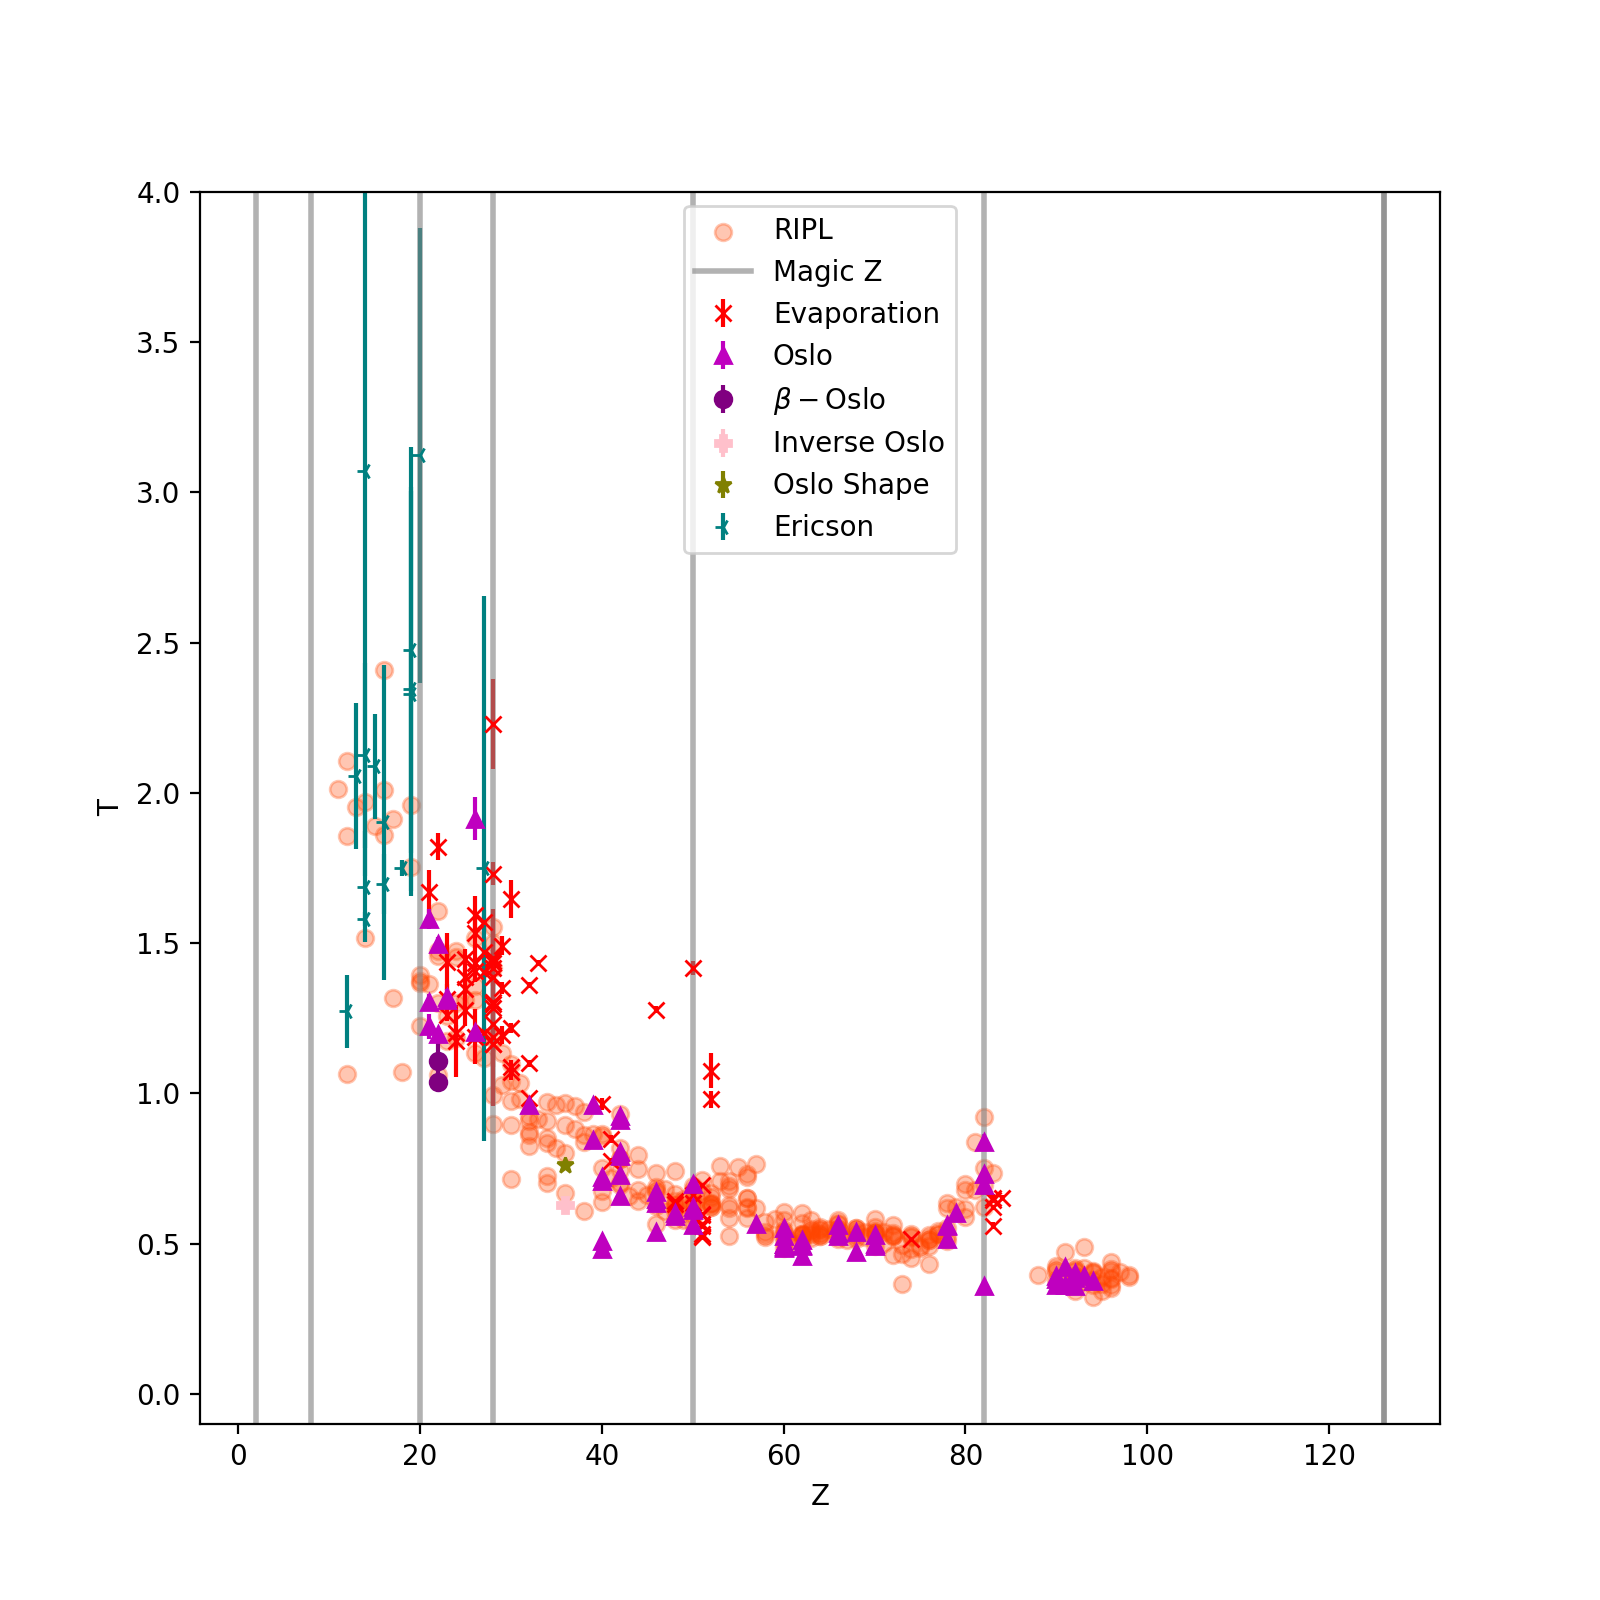

In [8]:
%matplotlib notebook

fig,ax = plt.subplots(figsize=(8,8))

plt.errorbar(df_evap['Z'],df_evap['T'],df_evap['dT'],color='r',fmt='x',label='Evaporation')
plt.errorbar(df_Oslo['Z'],df_Oslo['T'],df_Oslo['dT'],color='m',fmt='^',label='Oslo')
plt.errorbar(df_betaOslo['Z'],df_betaOslo['T'],df_betaOslo['dT'],color='purple',fmt='o',label=r'$\beta-$Oslo')
plt.errorbar(df_invOslo['Z'],df_invOslo['T'],df_invOslo['dT'],color='pink',fmt='P',label='Inverse Oslo')
plt.errorbar(df_Osloshape['Z'],df_Osloshape['T'],df_Osloshape['dT'],color='olive',fmt='*',label='Oslo Shape')
plt.errorbar(df_Ericson['Z'],df_Ericson['T'],df_Ericson['dT'],color='teal',fmt='3',label='Ericson')

plt.scatter(df_ripl_ctm['Z'],df_ripl_ctm['T'],color='orangered',alpha=0.3,label='RIPL')

for i in magic_z:
    plt.axvline(x=i,lw=2.0,color='grey',alpha=0.6)

plt.axvline(x=magic_z[-1],lw=2.0,color='grey',alpha=0.6,label='Magic Z')

# x,y = df_datafiles['Z'].to_list(), df_datafiles['T'].to_list()
# for i, txt in enumerate(df_datafiles['Z']):
#     ax.annotate(txt, (x[i], y[i]),fontsize=8)

plt.xlabel('Z')
plt.ylabel('T')
plt.legend()
plt.ylim(-0.1,4)
plt.show()


<IPython.core.display.Javascript object>


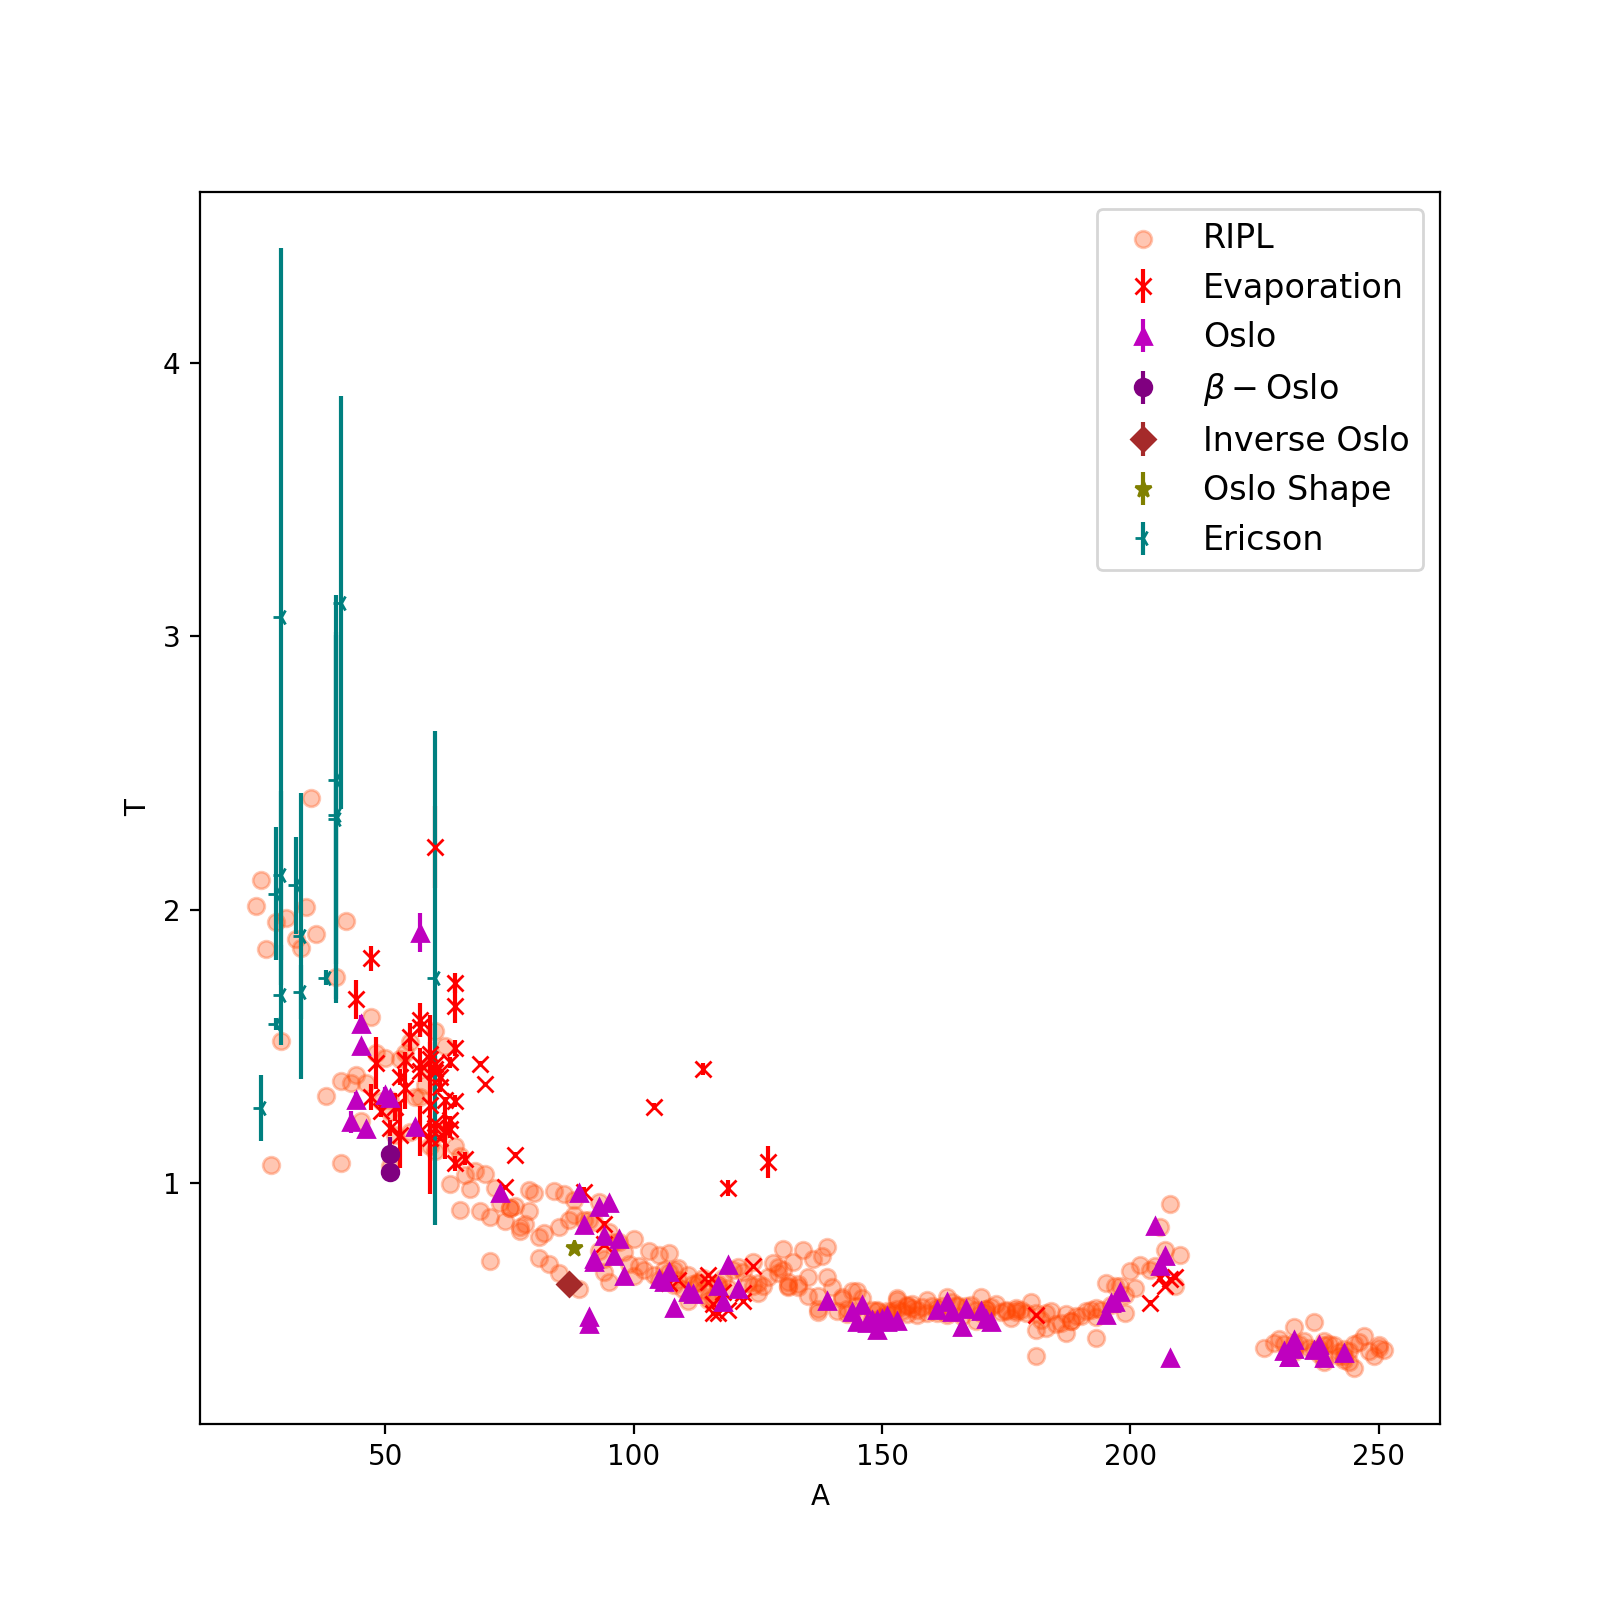

In [9]:
%matplotlib notebook

fig,ax = plt.subplots(figsize=(8,8))

plt.errorbar(df_evap['A'],df_evap['T'],df_evap['dT'],color='r',fmt='x',label='Evaporation')
plt.errorbar(df_Oslo['A'],df_Oslo['T'],df_Oslo['dT'],color='m',fmt='^',label='Oslo')
plt.errorbar(df_betaOslo['A'],df_betaOslo['T'],df_betaOslo['dT'],color='purple',fmt='o',label=r'$\beta-$Oslo')
plt.errorbar(df_invOslo['A'],df_invOslo['T'],df_invOslo['dT'],color='brown',fmt='D',label='Inverse Oslo')
plt.errorbar(df_Osloshape['A'],df_Osloshape['T'],df_Osloshape['dT'],color='olive',fmt='*',label='Oslo Shape')
plt.errorbar(df_Ericson['A'],df_Ericson['T'],df_Ericson['dT'],color='teal',fmt='3',label='Ericson')

plt.scatter(df_ripl_ctm['A'],df_ripl_ctm['T'],color='orangered',alpha=0.3,label='RIPL')

# for i in doubly_magic:
    
#     plt.axvline(x=i,lw=1.0,color='grey',alpha=0.6)
    
# plt.axvline(x=doubly_magic[-1],lw=1.0,color='grey',alpha=0.6,label='Doubly Magic')

# x,y = df_datafiles['A'].to_list(), df_datafiles['T'].to_list()
# for i, txt in enumerate(df_datafiles['A']):
#     ax.annotate(txt, (x[i], y[i]),fontsize=8)

plt.xlabel('A')
plt.ylabel('T')
plt.legend(fontsize=12)
#plt.ylim(-0.1,4)
plt.show()


<IPython.core.display.Javascript object>


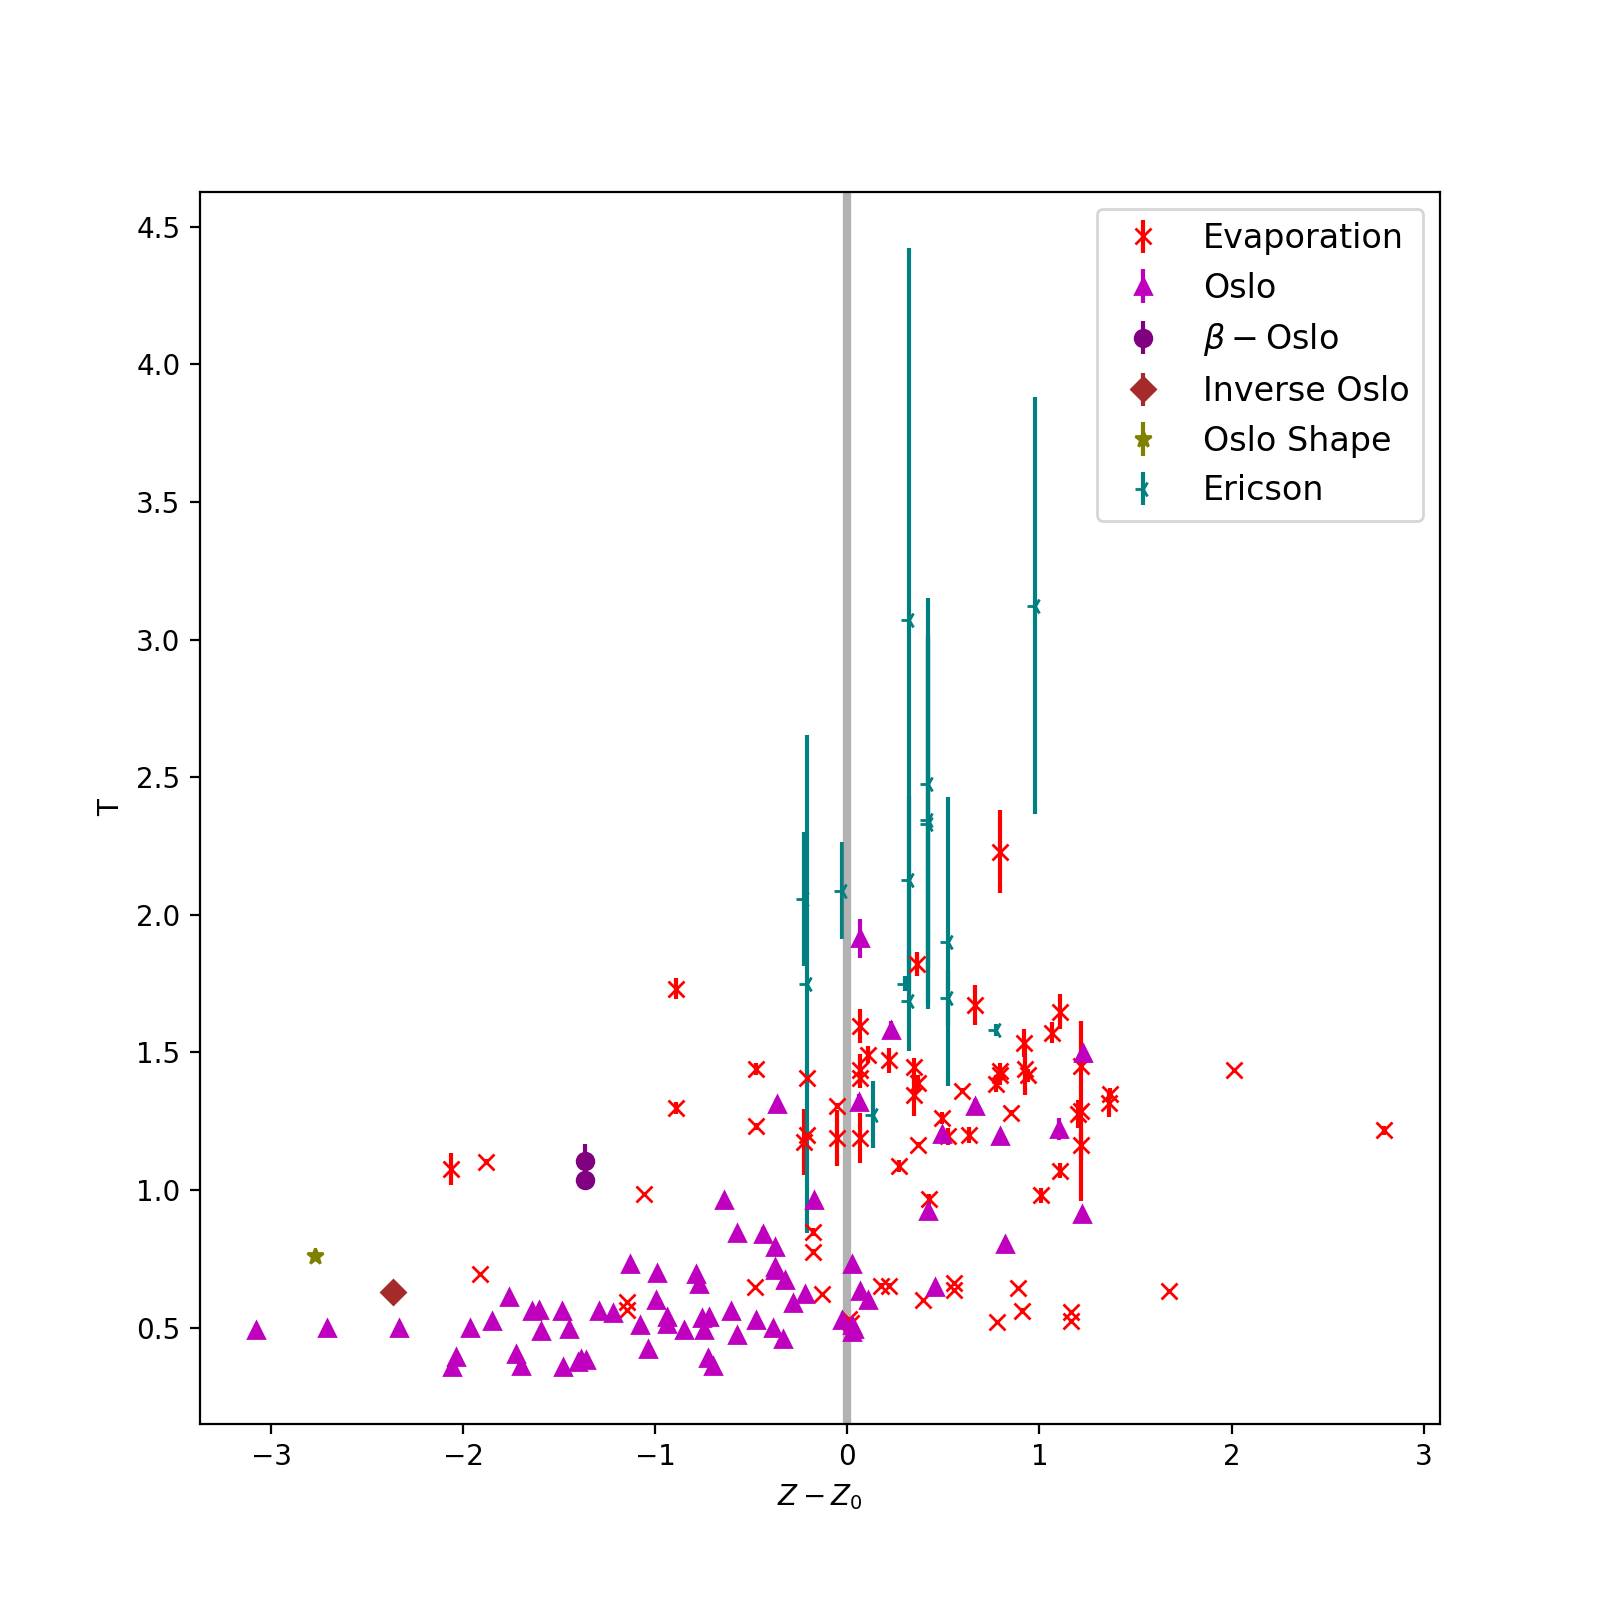

In [76]:
%matplotlib notebook

fig,ax = plt.subplots(figsize=(8,8))

plt.errorbar(df_evap['Distance'],df_evap['T'],df_evap['dT'],color='r',fmt='x',label='Evaporation')
plt.errorbar(df_Oslo['Distance'],df_Oslo['T'],df_Oslo['dT'],color='m',fmt='^',label='Oslo')
plt.errorbar(df_betaOslo['Distance'],df_betaOslo['T'],df_betaOslo['dT'],color='purple',fmt='o',label=r'$\beta-$Oslo')
plt.errorbar(df_invOslo['Distance'],df_invOslo['T'],df_invOslo['dT'],color='brown',fmt='D',label='Inverse Oslo')
plt.errorbar(df_Osloshape['Distance'],df_Osloshape['T'],df_Osloshape['dT'],color='olive',fmt='*',label='Oslo Shape')
plt.errorbar(df_Ericson['Distance'],df_Ericson['T'],df_Ericson['dT'],color='teal',fmt='3',label='Ericson')

plt.axvline(x=0.0,lw=3,color='grey',alpha=0.6)

#plt.scatter(df_ripl_ctm['Distance'],df_ripl_ctm['T'],color='orangered',alpha=0.3,label='RIPL')

# for i in doubly_magic:
    
#     plt.axvline(x=i,lw=1.0,color='grey',alpha=0.6)
    
# plt.axvline(x=doubly_magic[-1],lw=1.0,color='grey',alpha=0.6,label='Doubly Magic')

# x,y = df_datafiles['Distance'].to_list(), df_datafiles['T'].to_list()
# for i, txt in enumerate(df_datafiles['Distance']):
#     ax.annotate(txt, (x[i], y[i]),fontsize=8)

plt.xlabel(r'$Z - Z_0$')
plt.ylabel('T')
plt.legend(fontsize=12)
#plt.ylim(-0.1,4)
plt.show()


## Analysis of the energy back-shift ($E_0$) parameter

In [10]:
df_datafiles_odd_odd = df_datafiles[(df_datafiles['Z'] % 2 != 0) & ((df_datafiles['A'] - df_datafiles['Z']) % 2 != 0)]

df_datafiles_even_even = df_datafiles[(df_datafiles['Z'] % 2 == 0) & ((df_datafiles['A'] - df_datafiles['Z']) % 2 == 0)]

# Define the condition for the remaining rows, which are neither odd-odd nor even-even
df_datafiles_odd_even = df_datafiles[~((df_datafiles['Z'] % 2 != 0) & ((df_datafiles['A'] - df_datafiles['Z']) % 2 != 0)) & 
                           ~((df_datafiles['Z'] % 2 == 0) & ((df_datafiles['A'] - df_datafiles['Z']) % 2 == 0))]

df_datafiles_odd_odd.drop(1,inplace=True)

/var/folders/9d/120xs_y93rbgd7vklz1_82tm0000gn/T/ipykernel_63491/57889495.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_datafiles_odd_odd.drop(1,inplace=True)


<IPython.core.display.Javascript object>


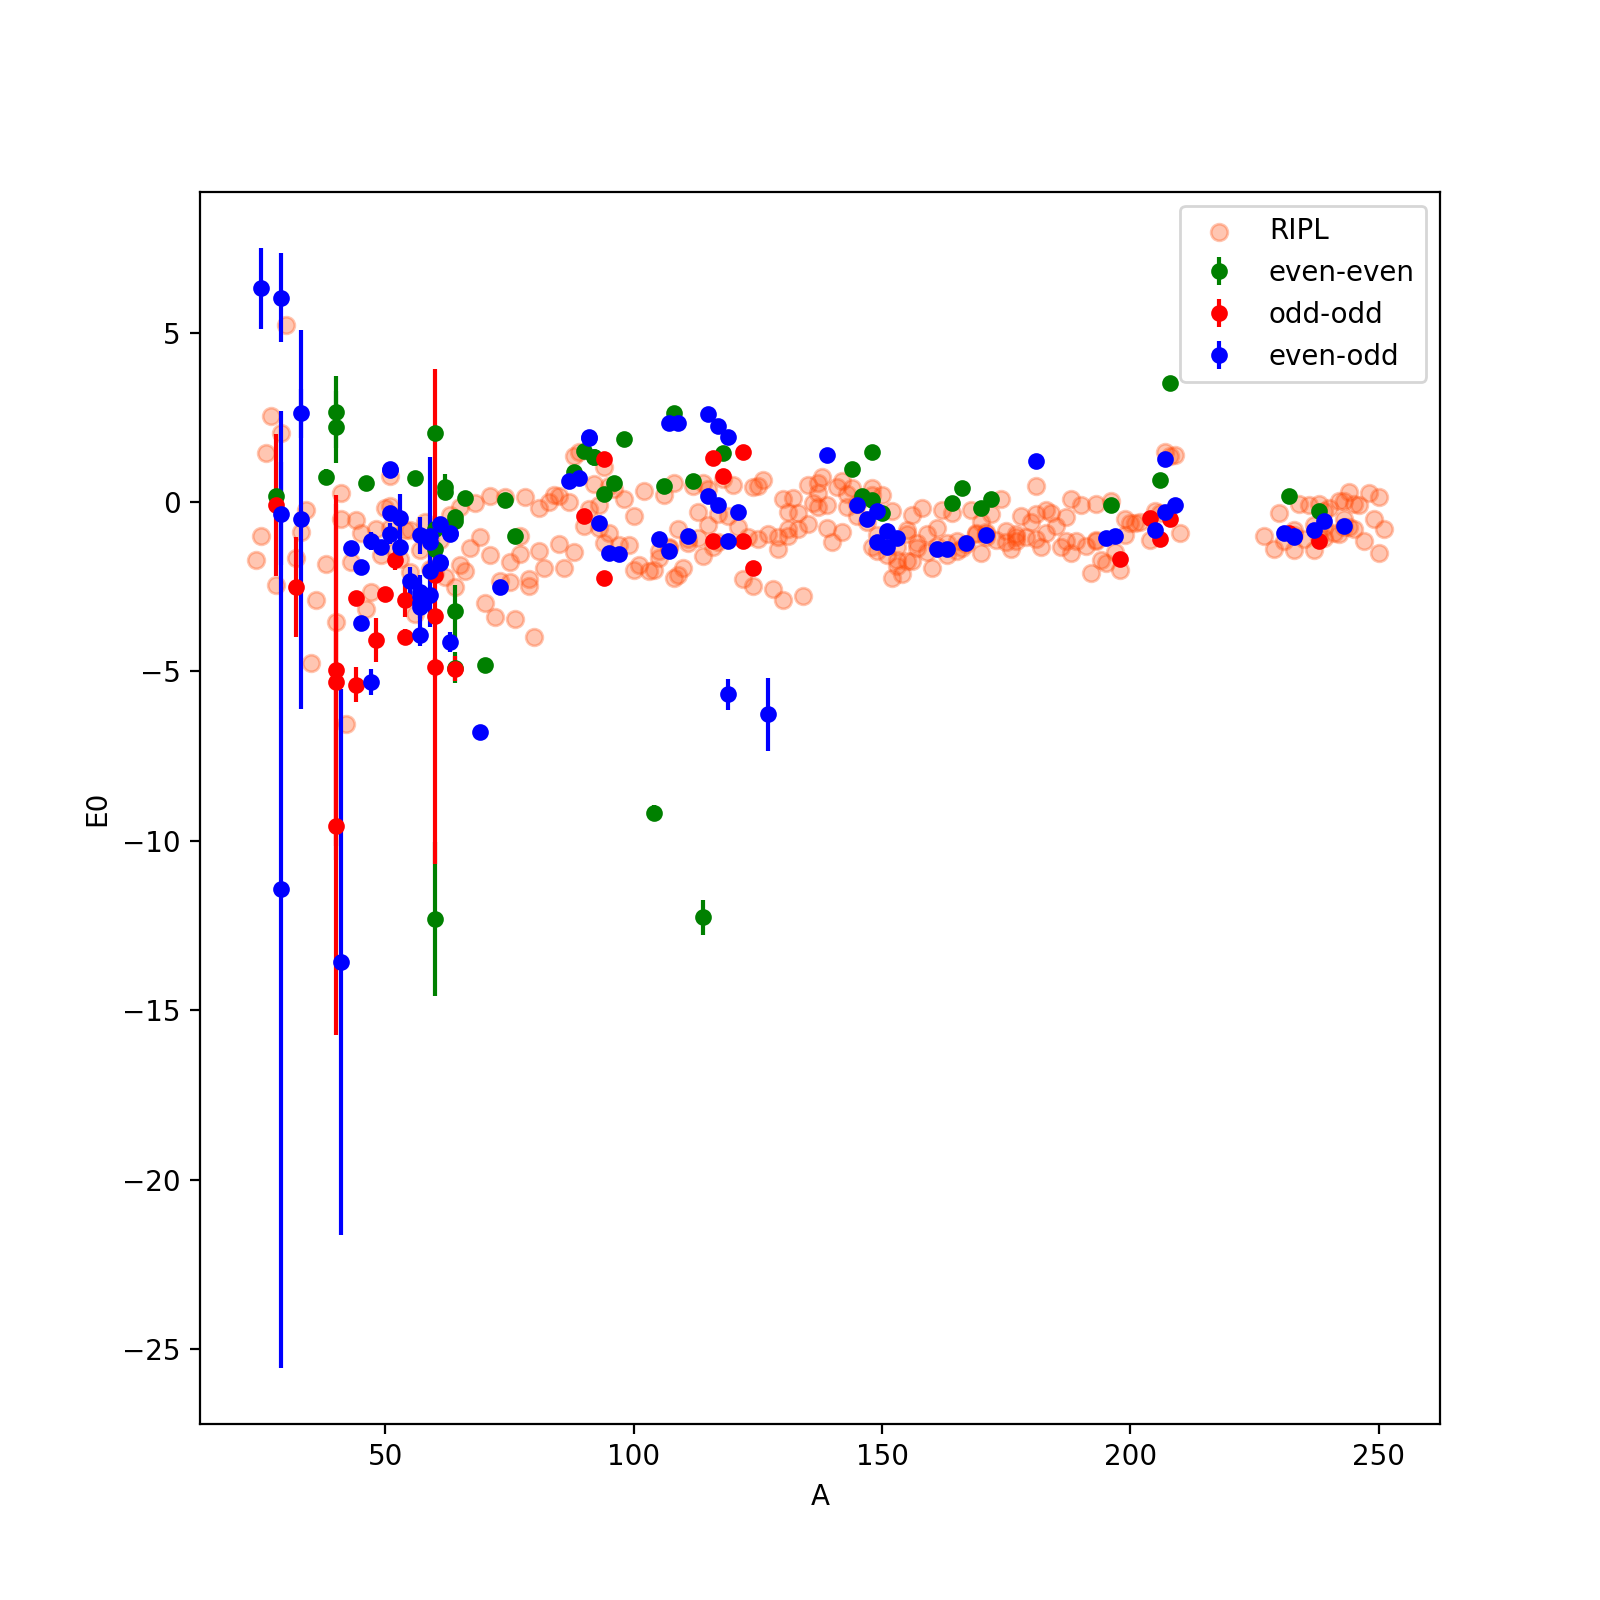

In [11]:
fig,ax = plt.subplots(figsize=(8,8))

plt.errorbar(df_datafiles_even_even['A'],df_datafiles_even_even['E0'],df_datafiles_even_even['dE0'], 
             fmt = 'o',color='g',ms=5,label='even-even')
plt.errorbar(df_datafiles_odd_odd['A'],df_datafiles_odd_odd['E0'],df_datafiles_odd_odd['dE0'], 
             fmt = 'o',color='r',ms=5,label='odd-odd')
plt.errorbar(df_datafiles_odd_even['A'],df_datafiles_odd_even['E0'],df_datafiles_odd_even['dE0'], 
             fmt = 'o',color='b',ms=5,label='even-odd')

plt.scatter(df_ripl_ctm['A'],df_ripl_ctm['E0'],color='orangered',alpha=0.3,label='RIPL')

# x,y = df_datafiles['A'].to_list(), df_datafiles['E0'].to_list()
# for i, txt in enumerate(df_datafiles['A']):
#     ax.annotate(txt, (x[i], y[i]),fontsize=8)
    
plt.xlabel('A')
plt.ylabel('E0')
plt.legend()
#plt.ylim(-10,10)
plt.show()


<IPython.core.display.Javascript object>


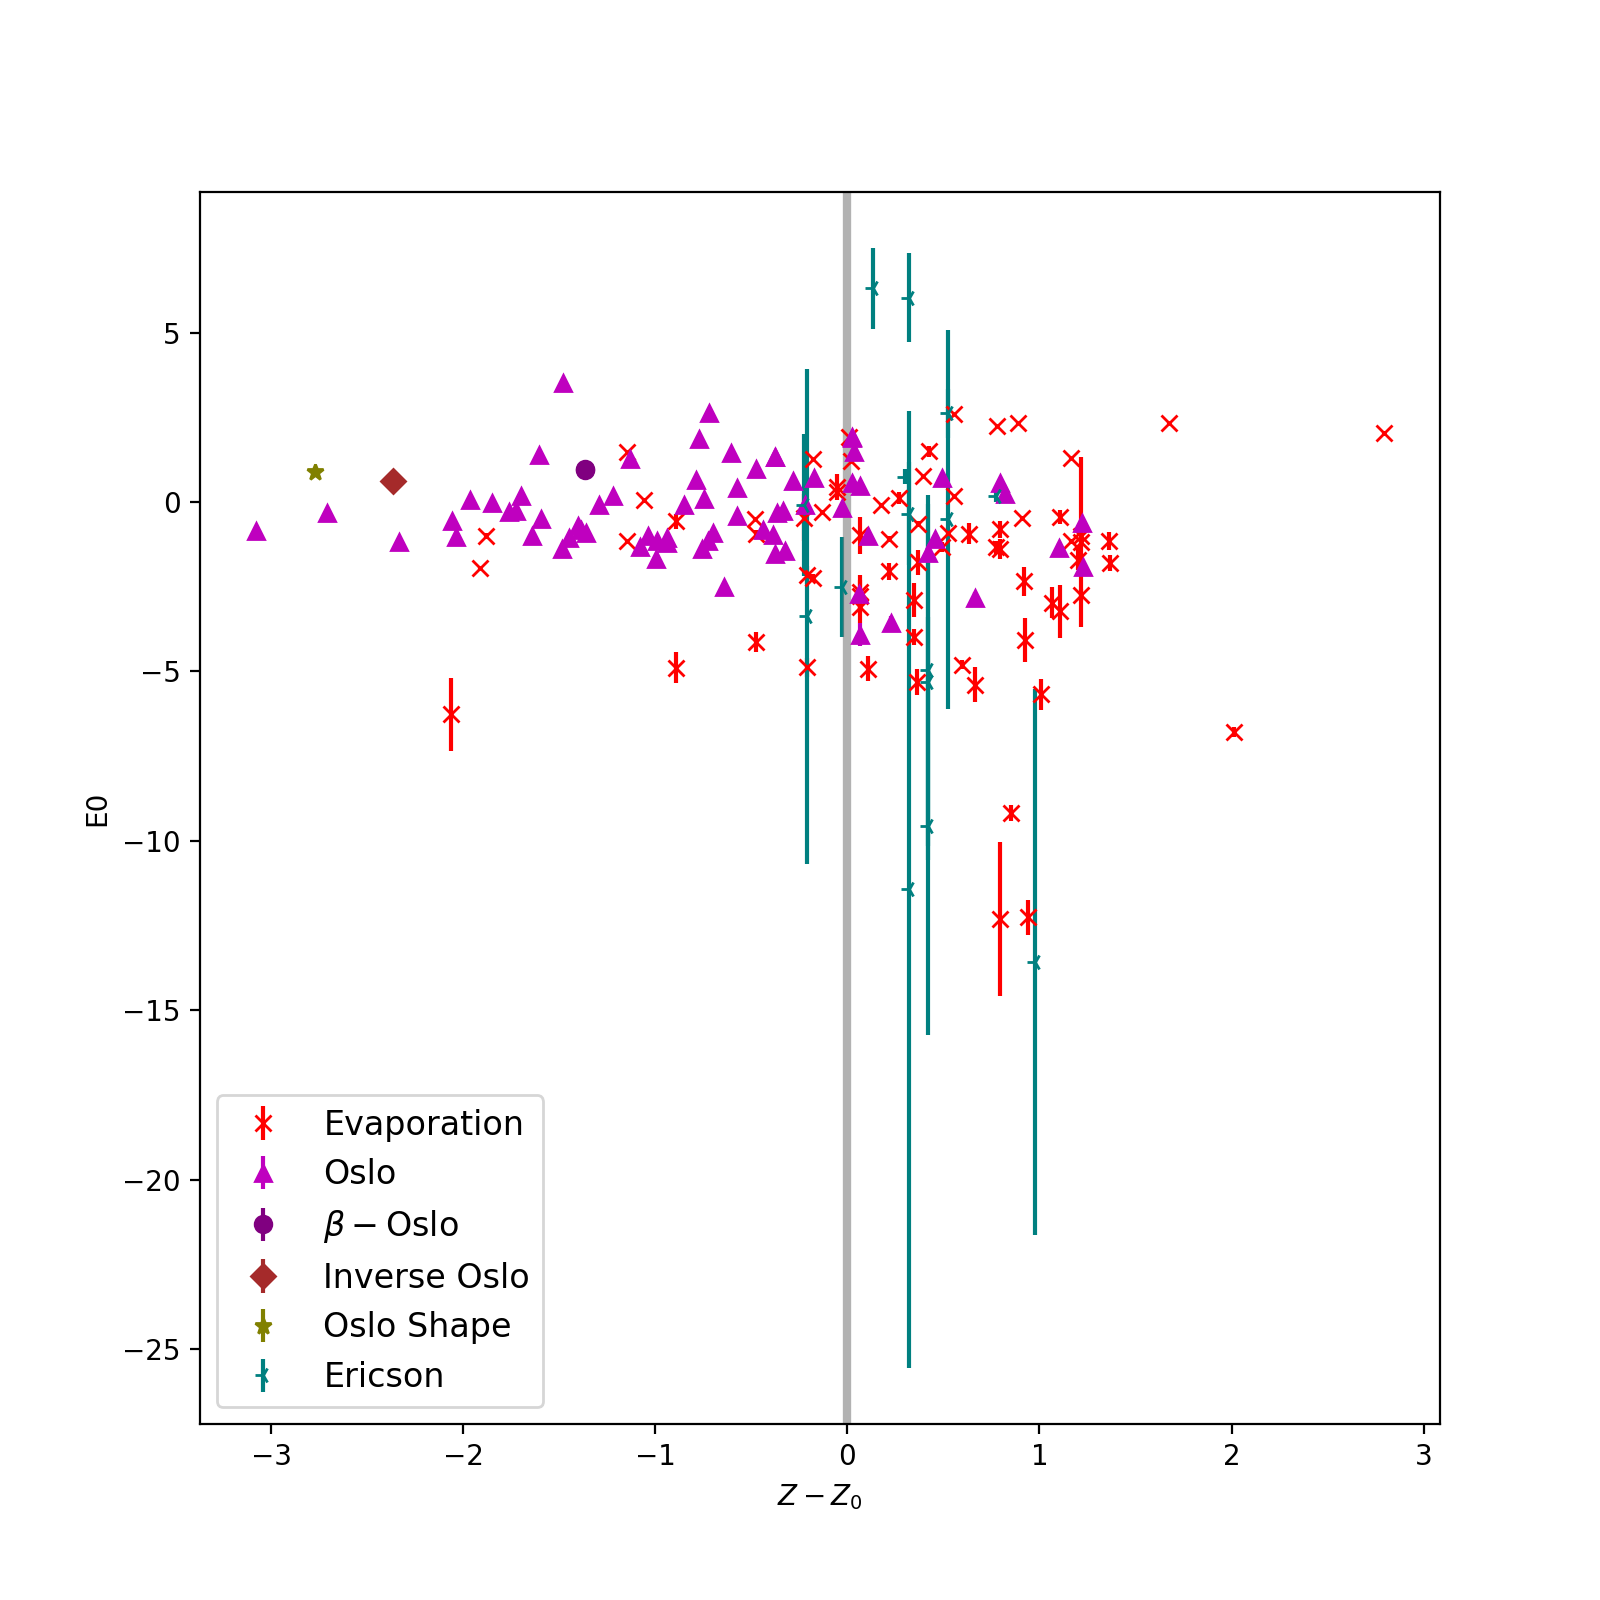

In [78]:
%matplotlib notebook

fig,ax = plt.subplots(figsize=(8,8))

plt.errorbar(df_evap['Distance'],df_evap['E0'],df_evap['dE0'],color='r',fmt='x',label='Evaporation')
plt.errorbar(df_Oslo['Distance'],df_Oslo['E0'],df_Oslo['dE0'],color='m',fmt='^',label='Oslo')
plt.errorbar(df_betaOslo['Distance'],df_betaOslo['E0'],df_betaOslo['dE0'],color='purple',fmt='o',label=r'$\beta-$Oslo')
plt.errorbar(df_invOslo['Distance'],df_invOslo['E0'],df_invOslo['dE0'],color='brown',fmt='D',label='Inverse Oslo')
plt.errorbar(df_Osloshape['Distance'],df_Osloshape['E0'],df_Osloshape['dE0'],color='olive',fmt='*',label='Oslo Shape')
plt.errorbar(df_Ericson['Distance'],df_Ericson['E0'],df_Ericson['dE0'],color='teal',fmt='3',label='Ericson')

plt.axvline(x=0.0,lw=3,color='grey',alpha=0.6)

#plt.scatter(df_ripl_ctm['Distance'],df_ripl_ctm[E0],color='orangered',alpha=0.3,label='RIPL')

# for i in doubly_magic:
    
#     plt.axvline(x=i,lw=1.0,color='grey',alpha=0.6)
    
# plt.axvline(x=doubly_magic[-1],lw=1.0,color='grey',alpha=0.6,label='Doubly Magic')

# x,y = df_datafiles['Distance'].to_list(), df_datafiles[E0].to_list()
# for i, txt in enumerate(df_datafiles['Distance']):
#     ax.annotate(txt, (x[i], y[i]),fontsize=8)

plt.xlabel(r'$Z - Z_0$')
plt.ylabel('E0')
plt.legend(fontsize=12)
#plt.ylim(-0.1,4)
plt.show()


## Comparison of $T_{fit}$ and $T_{RIPL}$

In [80]:
df_match = pd.merge(df_datafiles,df_ripl_ctm,on=['Z','A'],how='inner')

df_match = df_match.replace("-",np.NaN)

#df_match.to_excel('RIPL_match_all_methods.xlsx')

df_match_numeric = df_match.select_dtypes(include='number')
df_match_numeric = pd.DataFrame((df_match['Z'],df_match['A'],df_match['Deformation'],df_match['Distance'],
df_match['T_x'],df_match['E0_x'],df_match['dT'],df_match['dE0'],df_match['I0'],df_match['Bn'],df_match['D0'],
df_match['Derr'],df_match['Nlow'],df_match['Ulow'],df_match['Ntop'],df_match['Utop'],df_match['dW'],df_match['gamma'],
df_match['ainf'],df_match['aerr'],df_match['pairing'],df_match['Ematch'],df_match['T_y'],df_match['E0_y'])).astype(float)


df_match_numeric = df_match_numeric.T


In [81]:
df_Egidy = pd.read_csv('egidy_table_2.dat',comment='#',header=0, sep = '\s+')

df_Egidy_cut = df_Egidy.drop(['a','da','E1','dE1','atil','datil','E2','dE2'],axis=1)

df_Egidy_cut = df_Egidy_cut.rename(columns={'T':'T_Egidy','E0':'E0_Egidy','dT':'dT_Egidy','dE0':'dE0_Egidy'})

df_match_egidy = pd.merge(df_match,df_Egidy_cut,on=['Z','A'],how='inner')


df_match_egidy.drop(['index', 'Isotope', 'ID', 'Emin', 'Emax', 'Exrange',
       'Reaction', 'Deformation', 'Author', 'Reference', 'Datafile',
       'Comments', 'Status','El_x'],axis=1,inplace=True)

df_match_egidy['dT_RIPL'] = (df_match_egidy['dT_Egidy']/100)/df_match_egidy['T_Egidy'] * df_match_egidy['T_y']

df_match_egidy['dE0_RIPL'] = np.abs((df_match_egidy['dE0_Egidy']/100)/df_match_egidy['E0_Egidy'] * df_match_egidy['E0_y'])

df_match_egidy.drop(1,inplace=True)

df_match_egidy = df_match_egidy.reset_index()

In [82]:
df_match.shape

(108, 38)

In [83]:
ratio_T = []
ratio_E0 = []
for i in range(len(df_match_egidy)):
    
    T_ripl = ufloat(df_match_egidy['T_y'][i],df_match_egidy['dT_RIPL'][i])
    E_ripl = ufloat(df_match_egidy['E0_y'][i],df_match_egidy['dE0_RIPL'][i])
    T_fit = ufloat(df_match_egidy['T_x'][i],df_match_egidy['dT'][i])
    E_fit = ufloat(df_match_egidy['E0_x'][i],df_match_egidy['dE0'][i])
    
    ratio_T.append(T_fit/T_ripl)
    ratio_E0.append(E_fit/E_ripl)
    

T_nominal = [nominal_value(val) for val in ratio_T]
T_uncertainty = [std_dev(val) for val in ratio_T]

E0_nominal = [nominal_value(val) for val in ratio_E0]
E0_uncertainty = [std_dev(val) for val in ratio_E0]

<IPython.core.display.Javascript object>


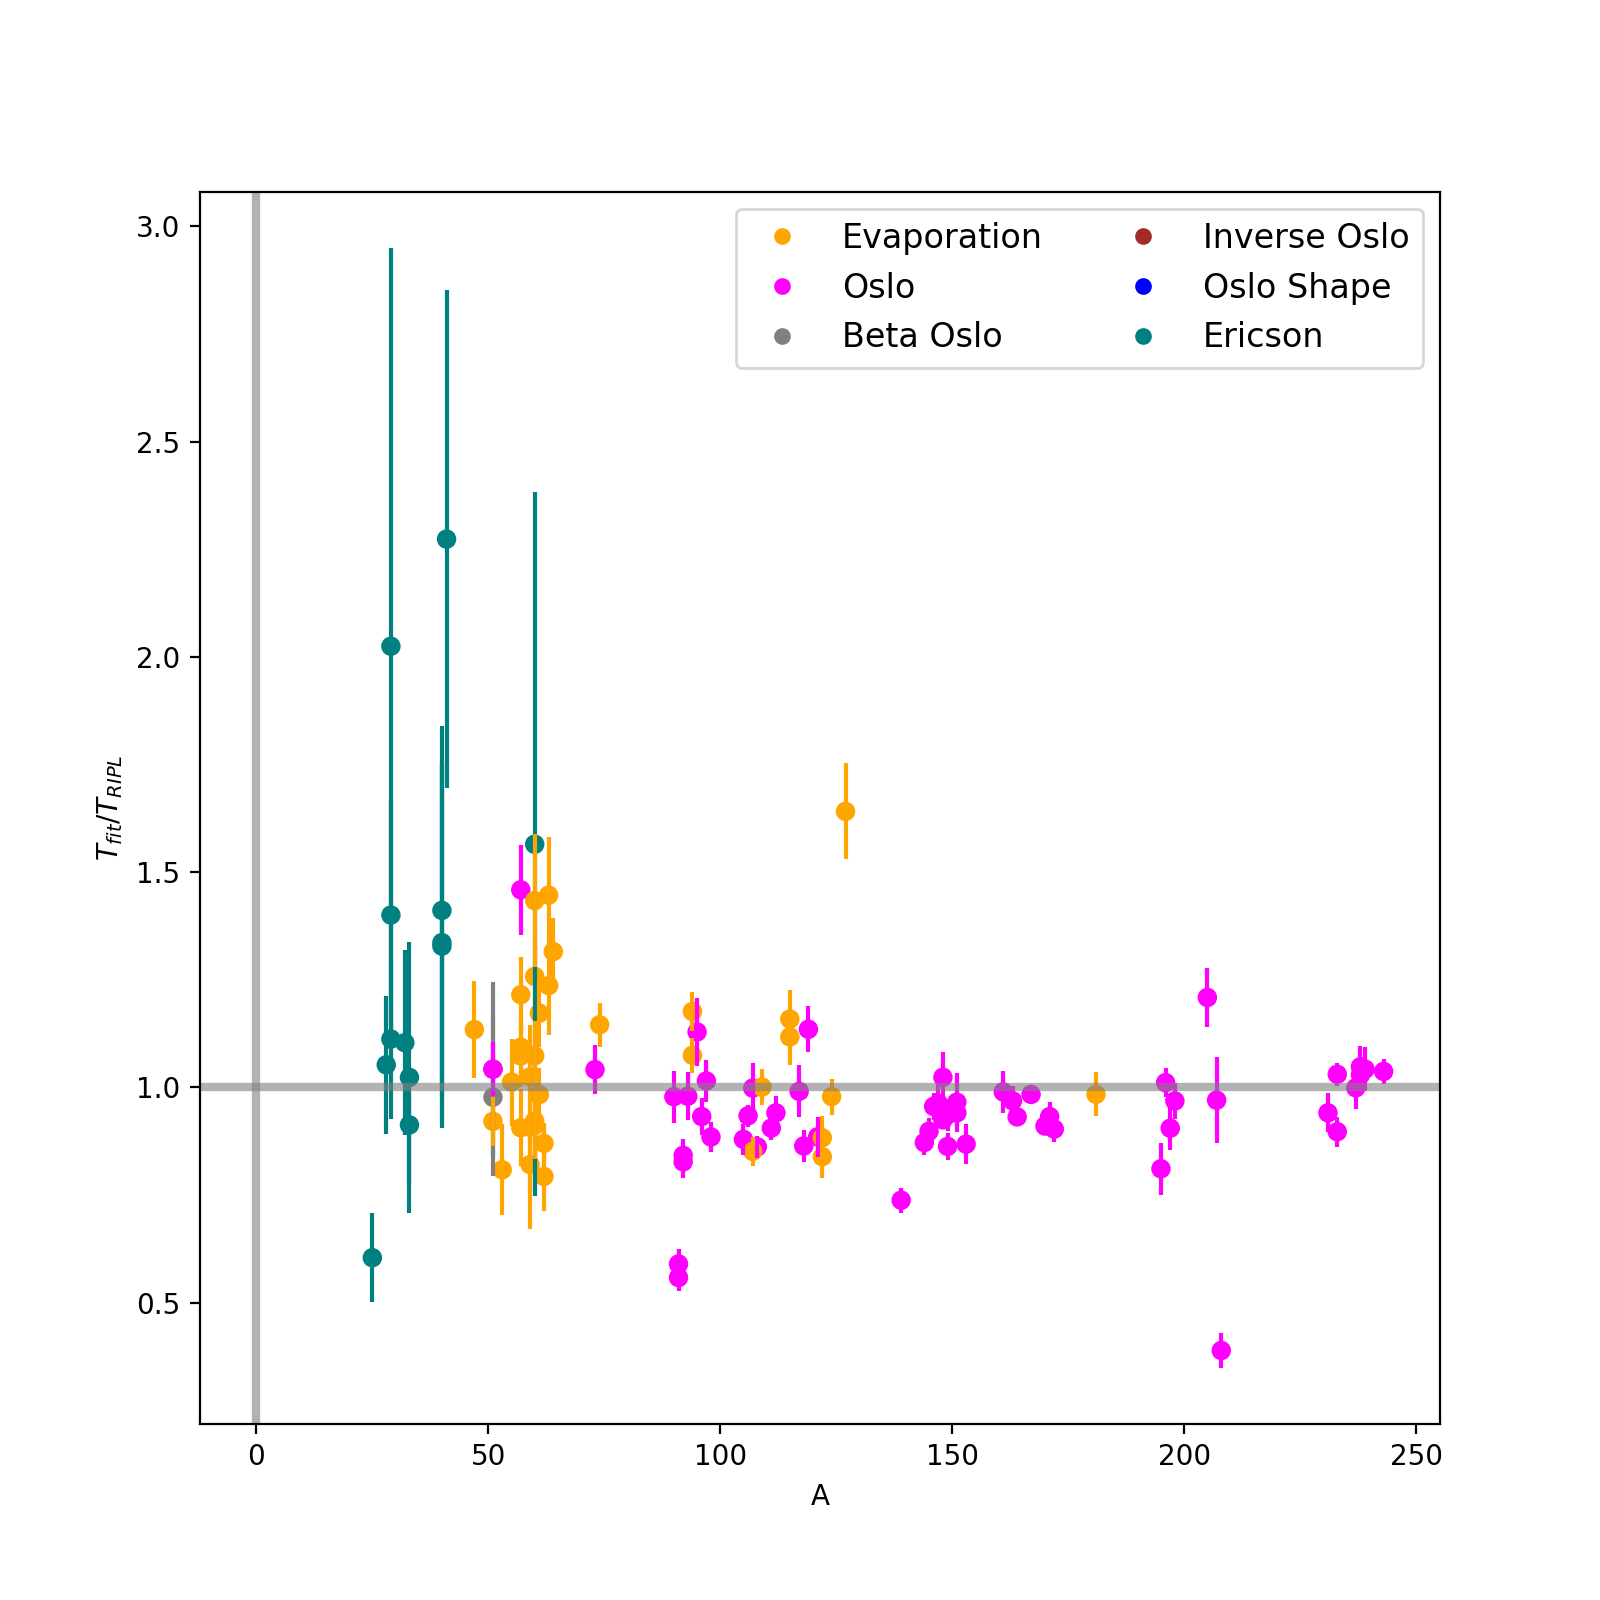

In [85]:
fig,ax = plt.subplots(figsize=(8,8))

colors = {'Evaporation': 'orange', 'Oslo': 'magenta', 
          'Beta Oslo': 'grey','Inverse Oslo':'brown','Oslo Shape':'blue','Ericson':'teal'}

ax.errorbar(df_match_egidy['A'],T_nominal,T_uncertainty,fmt='.',color='none',
             ecolor=df_match_egidy['Method'].map(colors))

ax.scatter(df_match_egidy['A'],T_nominal,marker='o',
            color=df_match_egidy['Method'].map(colors))

plt.axhline(y=1.0,lw=3,color='grey',alpha=0.6)
plt.axvline(x=0.0,lw=3,color='grey',alpha=0.6)
#plt.ylim(-0.5,4)
#plt.yscale('log')
plt.xlabel('A')
plt.ylabel(r'$T_{fit}/T_{RIPL}$')
handles = [Line2D([0], [0], linestyle='', marker='.', color=v, label=k, markersize=10) for k, v in colors.items()]
ax.legend(handles=handles, loc='best', ncol=2, fontsize=12)

plt.show()

<IPython.core.display.Javascript object>


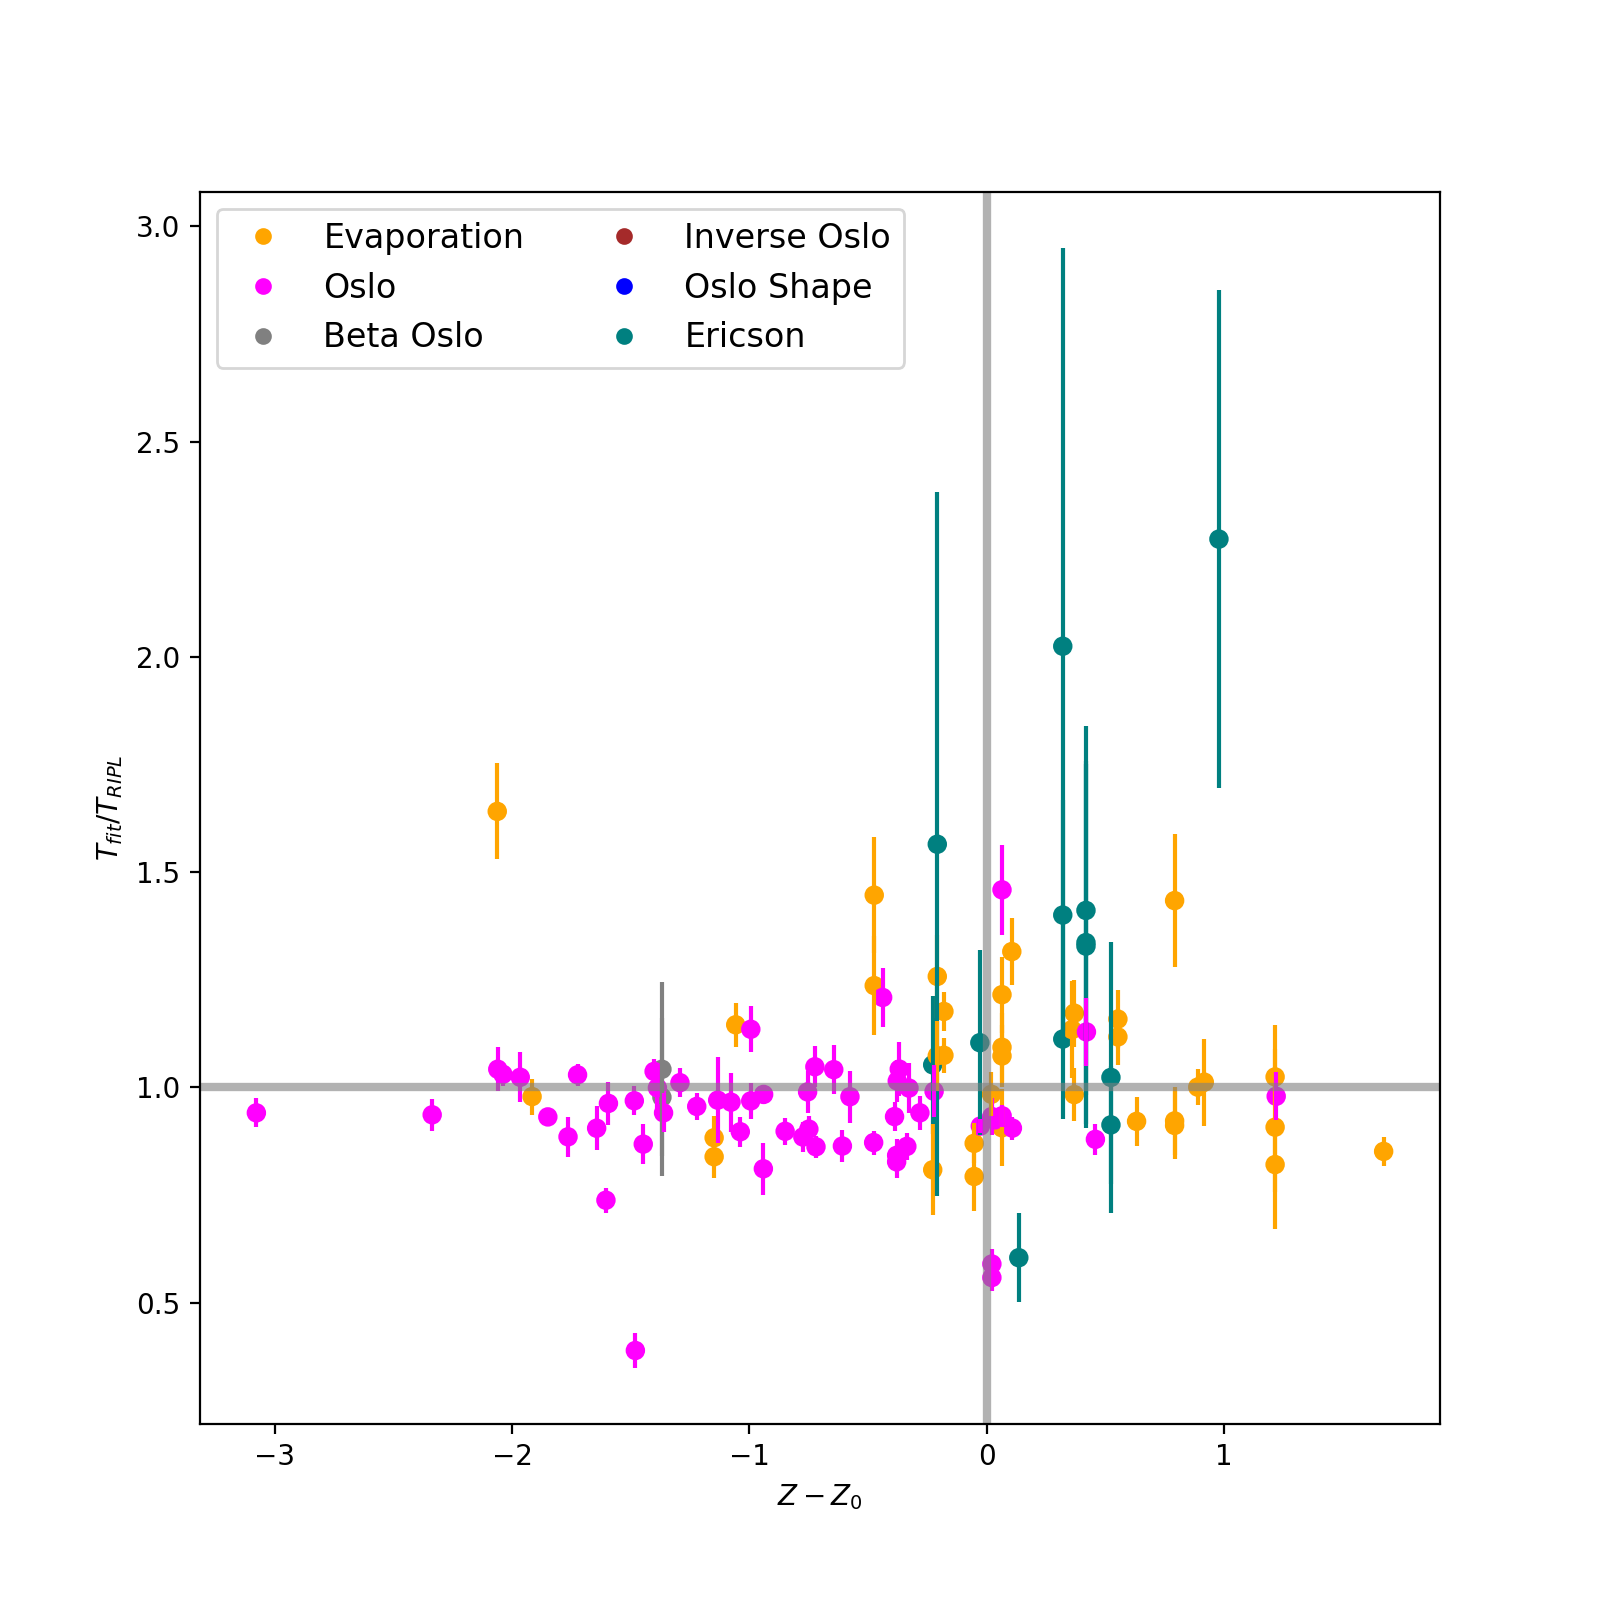

In [24]:
fig,ax = plt.subplots(figsize=(8,8))

ax.errorbar(df_match_egidy['Distance'],T_nominal,T_uncertainty,fmt='.',color='none',
             ecolor=df_match_egidy['Method'].map(colors))

ax.scatter(df_match_egidy['Distance'],T_nominal,marker='o',
            color=df_match_egidy['Method'].map(colors))


plt.axhline(y=1.0,lw=3,color='grey',alpha=0.6)
plt.axvline(x=0.0,lw=3,color='grey',alpha=0.6)

plt.xlabel(r'$Z - Z_0$')
plt.ylabel(r'$T_{fit}/T_{RIPL}$')

handles = [Line2D([0], [0], linestyle='', marker='.', color=v, label=k, markersize=10) for k, v in colors.items()]
ax.legend(handles=handles, loc='best', ncol=2, fontsize=12)

plt.show()

<IPython.core.display.Javascript object>


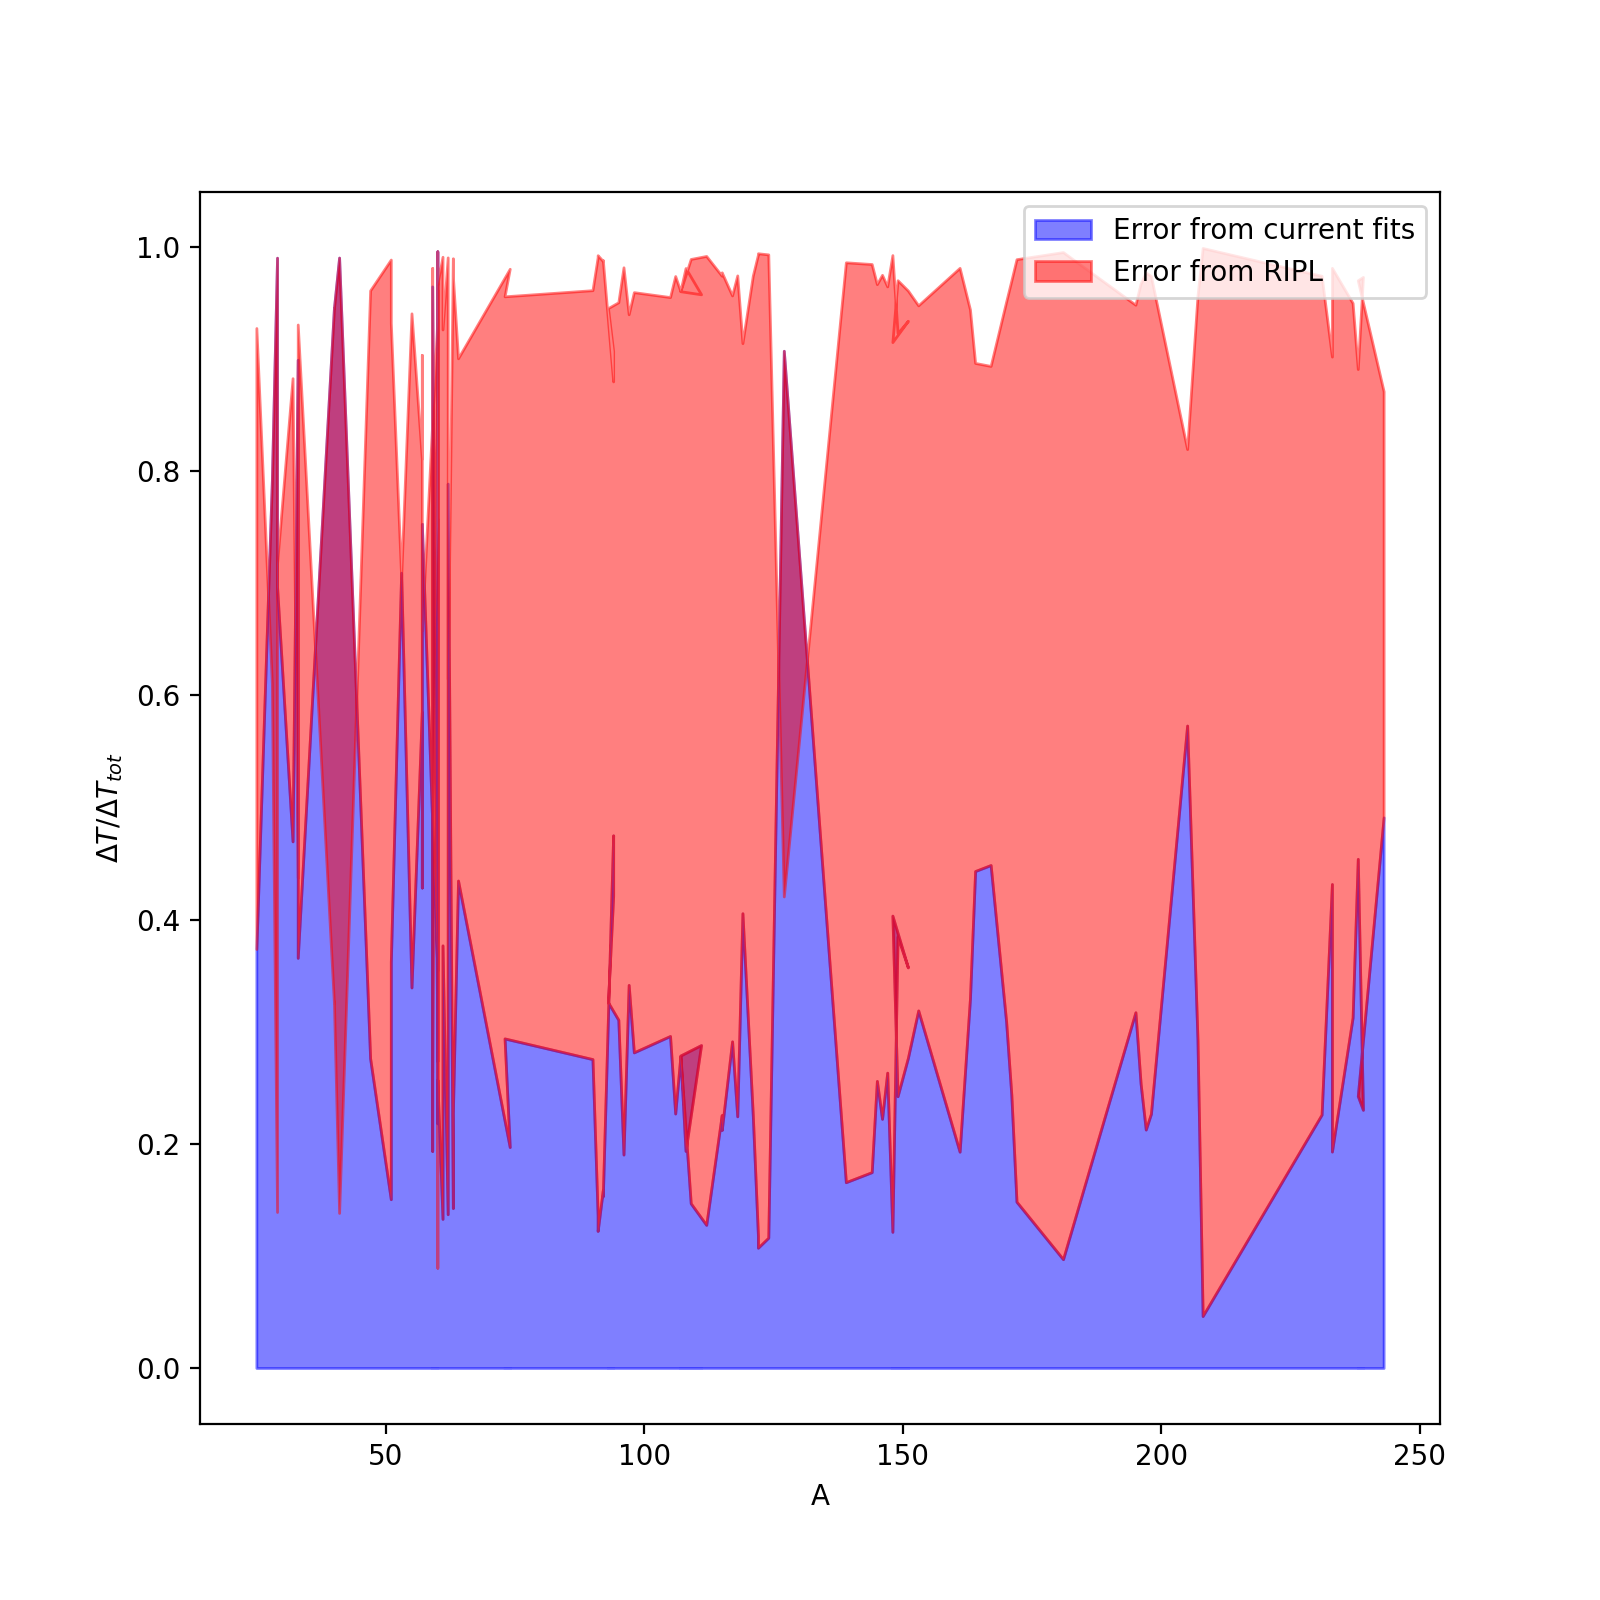

In [44]:
fig,ax = plt.subplots(figsize=(8,8))

T_total_error = np.sqrt(df_match_egidy['dT']**2 + df_match_egidy['dT_RIPL']**2)

plt.fill_between(df_match_egidy['A'], 0, df_match_egidy['dT']/T_total_error, color='blue', alpha=0.5, label='Error from current fits')
plt.fill_between(df_match_egidy['A'], df_match_egidy['dT']/T_total_error, df_match_egidy['dT_RIPL']/T_total_error, color='red', alpha=0.5, label='Error from RIPL')


# plt.scatter(df_match_egidy['A'],y_total_error,color='m')

# x,y = df_match_ripl['A'].to_list(), y_total_error.to_list()
# for i, txt in enumerate(df_match_ripl['A']):
#     ax.annotate(txt, (x[i], y[i]),fontsize=8)
    
#plt.plot(df_match_egidy['A'], T_total_error, color='black', linestyle='--', label='Total Error')
plt.legend()
#plt.ylim(0,0.2)
plt.xlabel('A')
plt.ylabel(r'$\Delta T / \Delta T_{tot}$')
plt.show()


<IPython.core.display.Javascript object>


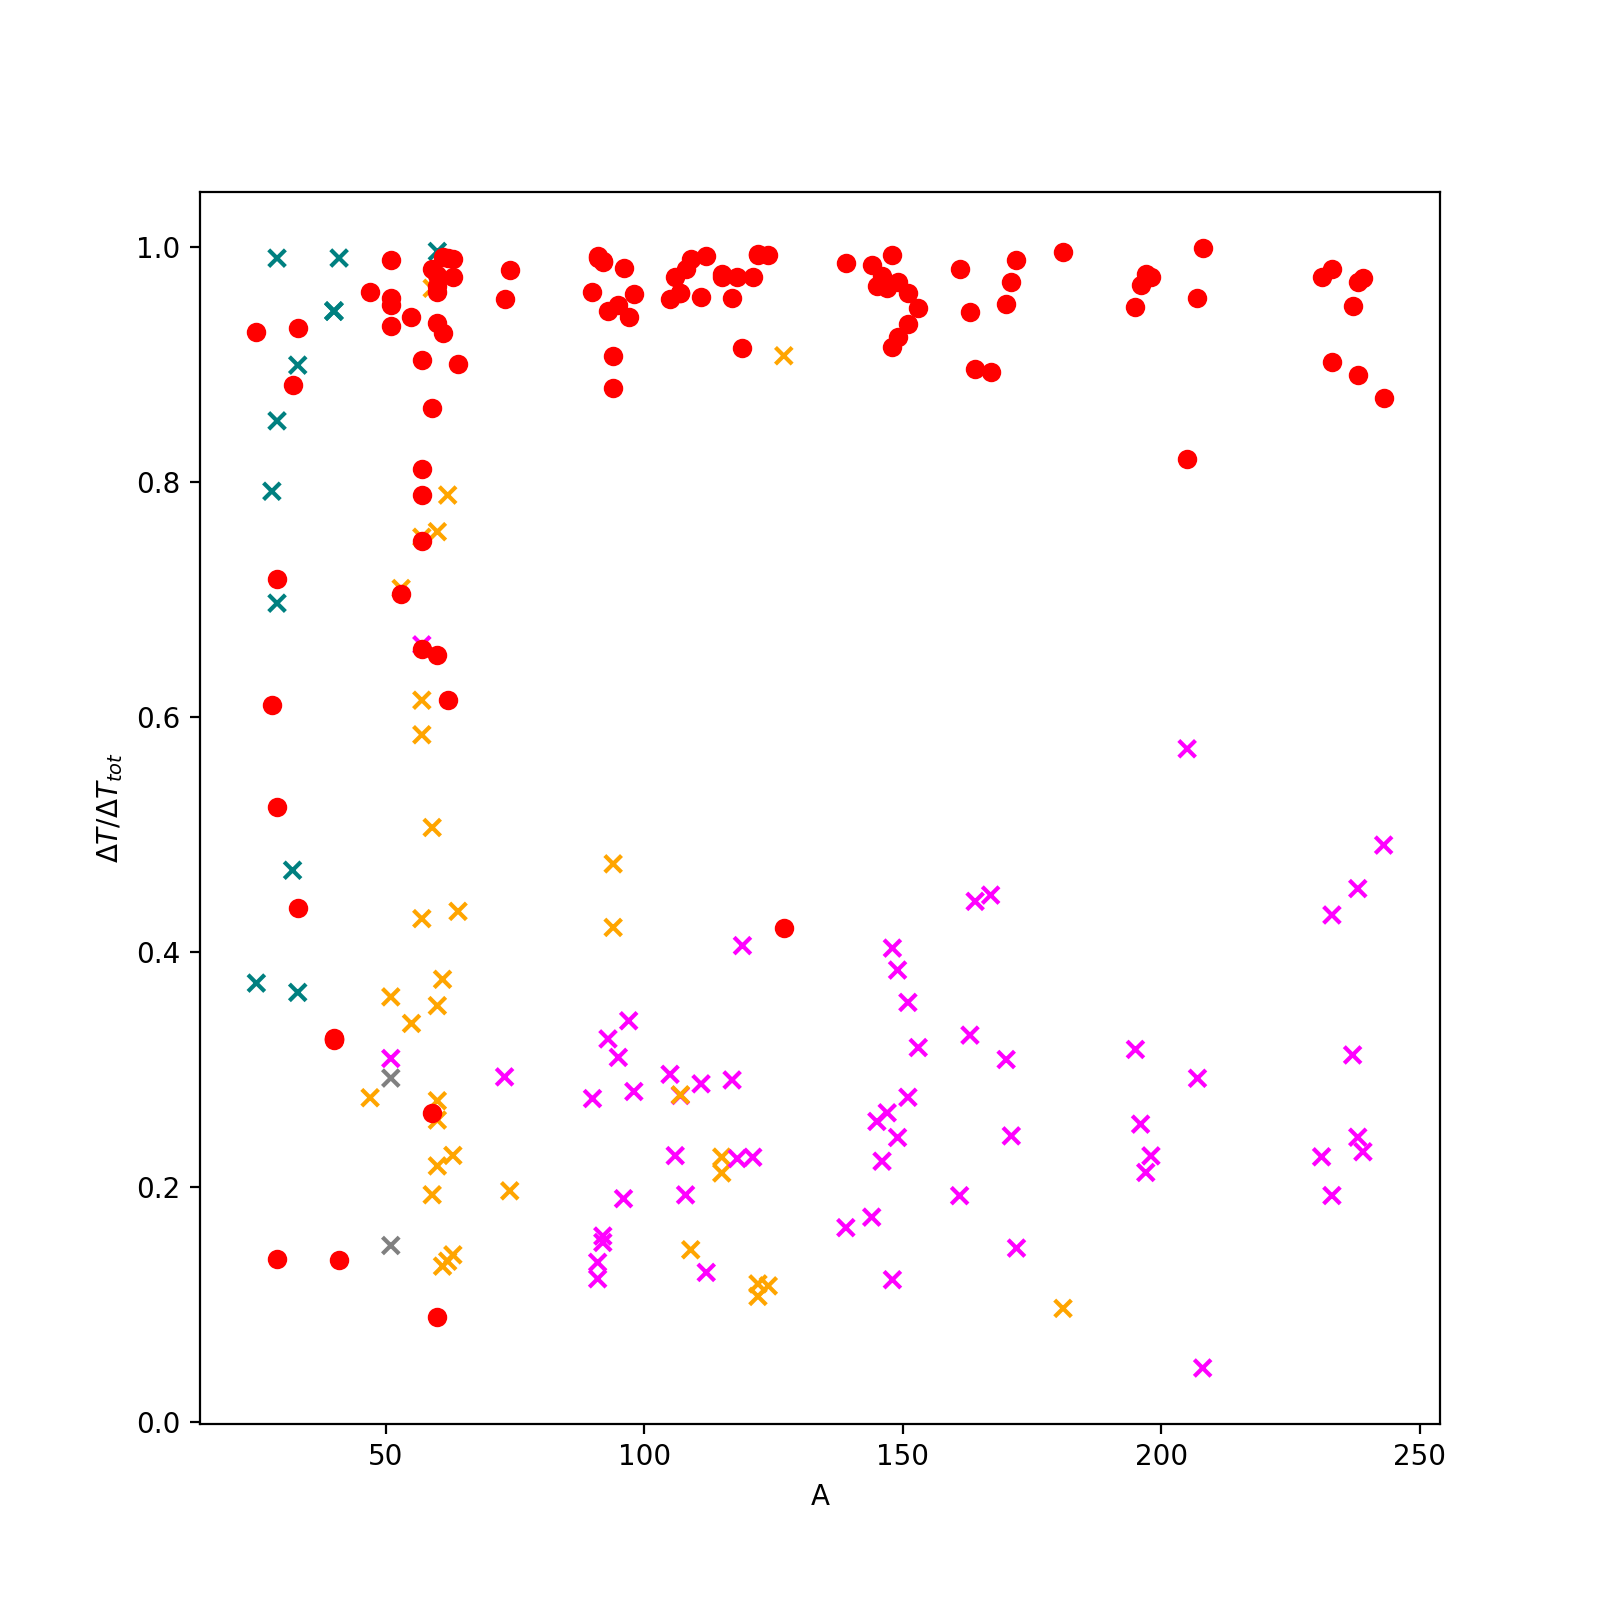

{'Evaporation': 'orange', 'Oslo': 'magenta', 'Beta Oslo': 'grey', 'Inverse Oslo': 'brown', 'Oslo Shape': 'blue', 'Ericson': 'teal'}


In [87]:
fig,ax = plt.subplots(figsize=(8,8))

T_total_error = np.sqrt(df_match_egidy['dT']**2 + df_match_egidy['dT_RIPL']**2)

plt.scatter(df_match_egidy['A'],df_match_egidy['dT']/T_total_error, 
            color=df_match_egidy['Method'].map(colors), marker='x', label='Error from current fits')

plt.scatter(df_match_egidy['A'], df_match_egidy['dT_RIPL']/T_total_error, 
            color='red',marker='o', label='Error from RIPL')


# plt.scatter(df_match_egidy['A'],y_total_error,color='m')

# x,y = df_match_ripl['A'].to_list(), y_total_error.to_list()
# for i, txt in enumerate(df_match_ripl['A']):
#     ax.annotate(txt, (x[i], y[i]),fontsize=8)
    
#plt.plot(df_match_egidy['A'], T_total_error, color='black', linestyle='--', label='Total Error')

#plt.ylim(0,0.2)
plt.xlabel('A')
plt.ylabel(r'$\Delta T / \Delta T_{tot}$')

print(colors)
plt.show()


## Comparison of $E_{0,fit}$ and $E_{0,RIPL}$

<IPython.core.display.Javascript object>


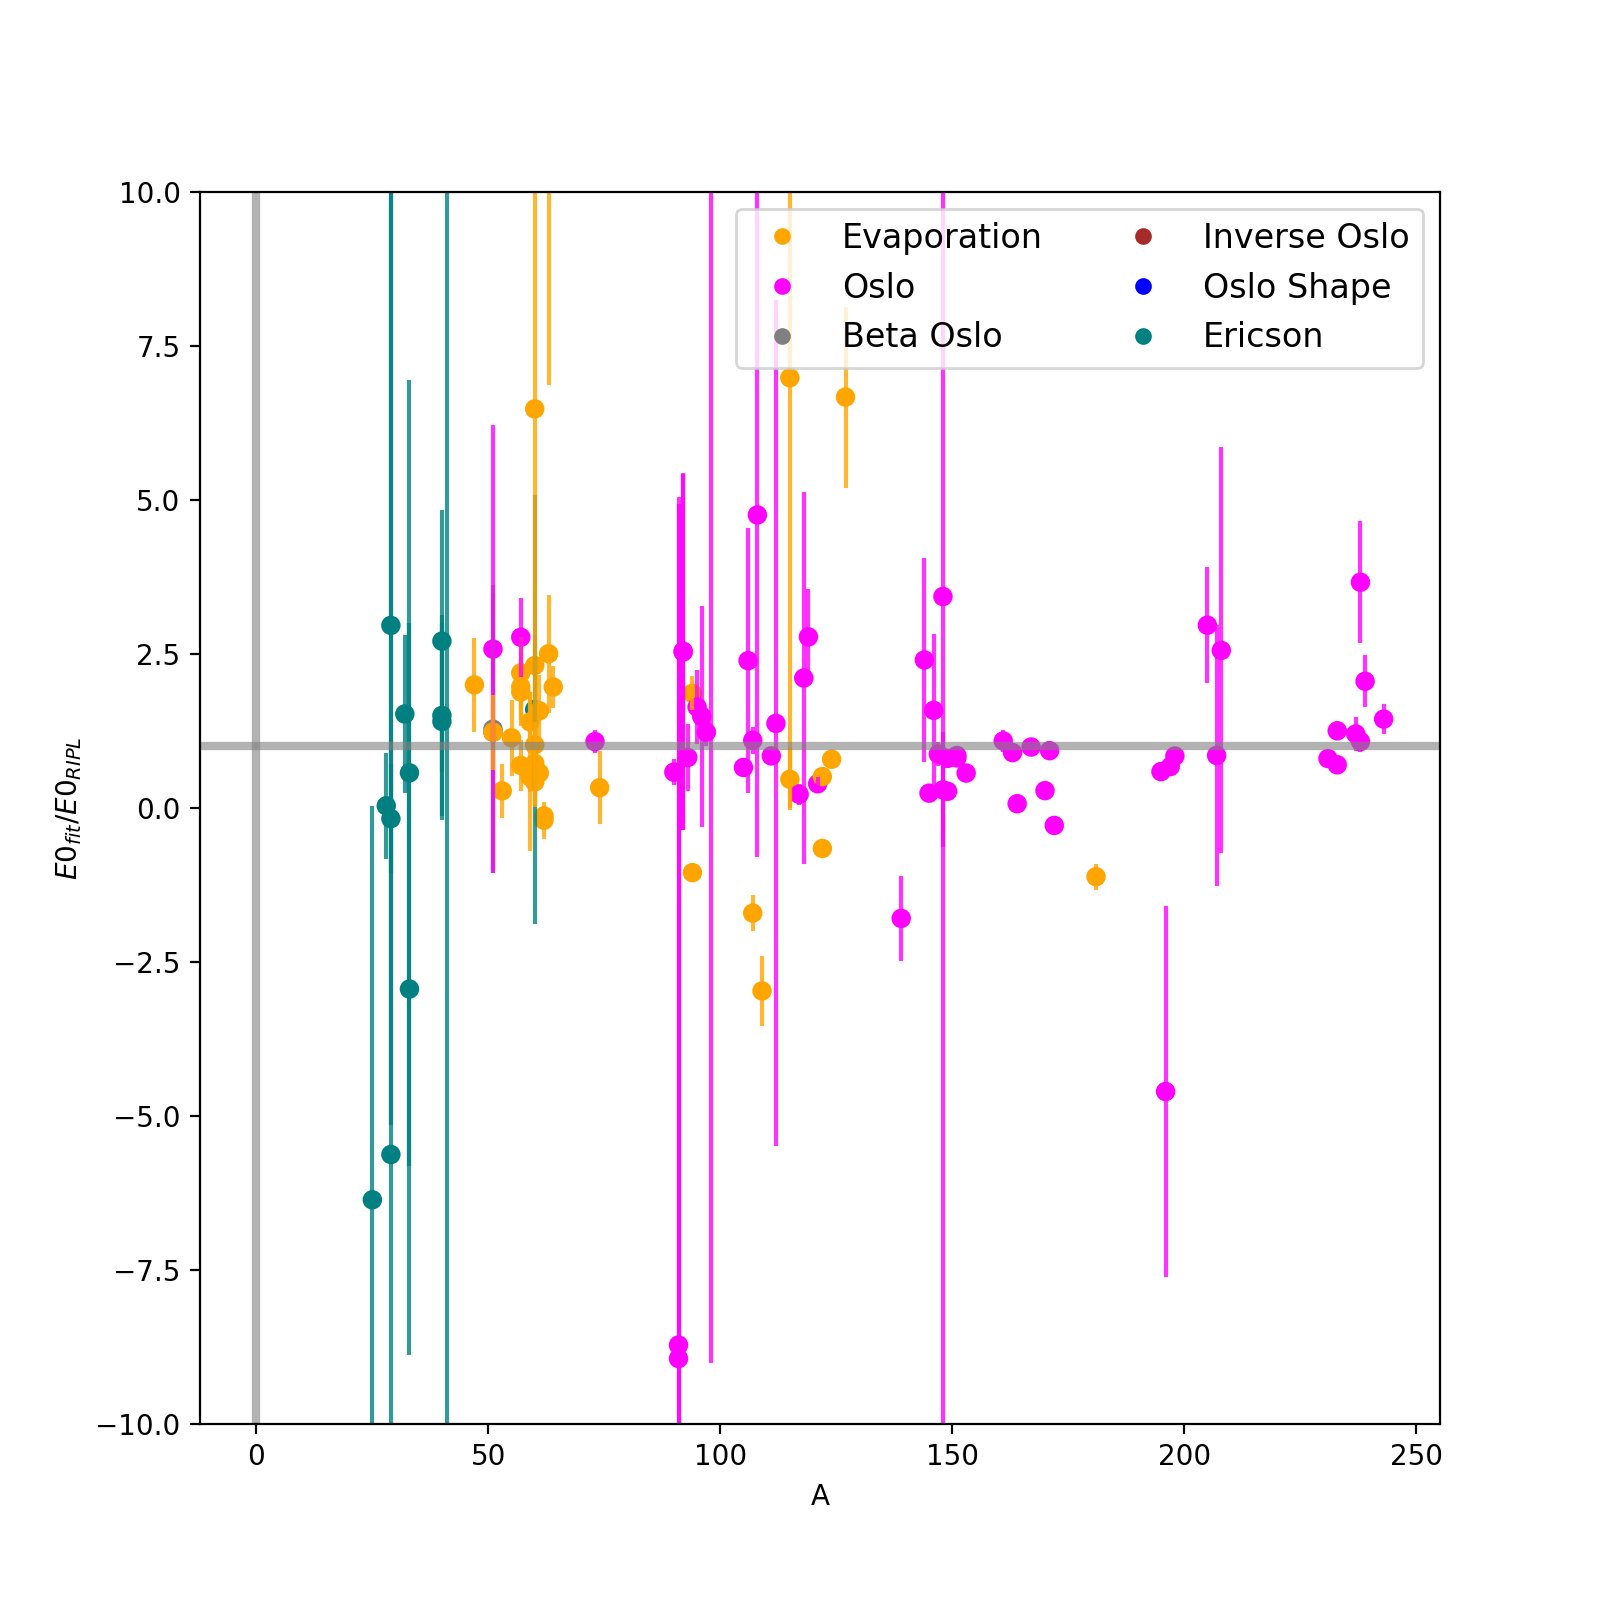

In [45]:
fig,ax = plt.subplots(figsize=(8,8))

ax.errorbar(df_match_egidy['A'],E0_nominal,E0_uncertainty,fmt='.',color='none',
            ecolor=df_match_egidy['Method'].map(colors),alpha=0.8)

ax.scatter(df_match_egidy['A'],E0_nominal,marker='o',
            color=df_match_egidy['Method'].map(colors))

plt.axhline(y=1.0,lw=3,color='grey',alpha=0.6)
plt.axvline(x=0.0,lw=3,color='grey',alpha=0.6)
plt.ylim(-10,10)
#plt.yscale('log')
plt.xlabel('A')
plt.ylabel(r'$E0_{fit}/E0_{RIPL}$')
handles = [Line2D([0], [0], linestyle='', marker='.', color=v, label=k, markersize=10) for k, v in colors.items()]
ax.legend(handles=handles, loc='best', ncol=2, fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


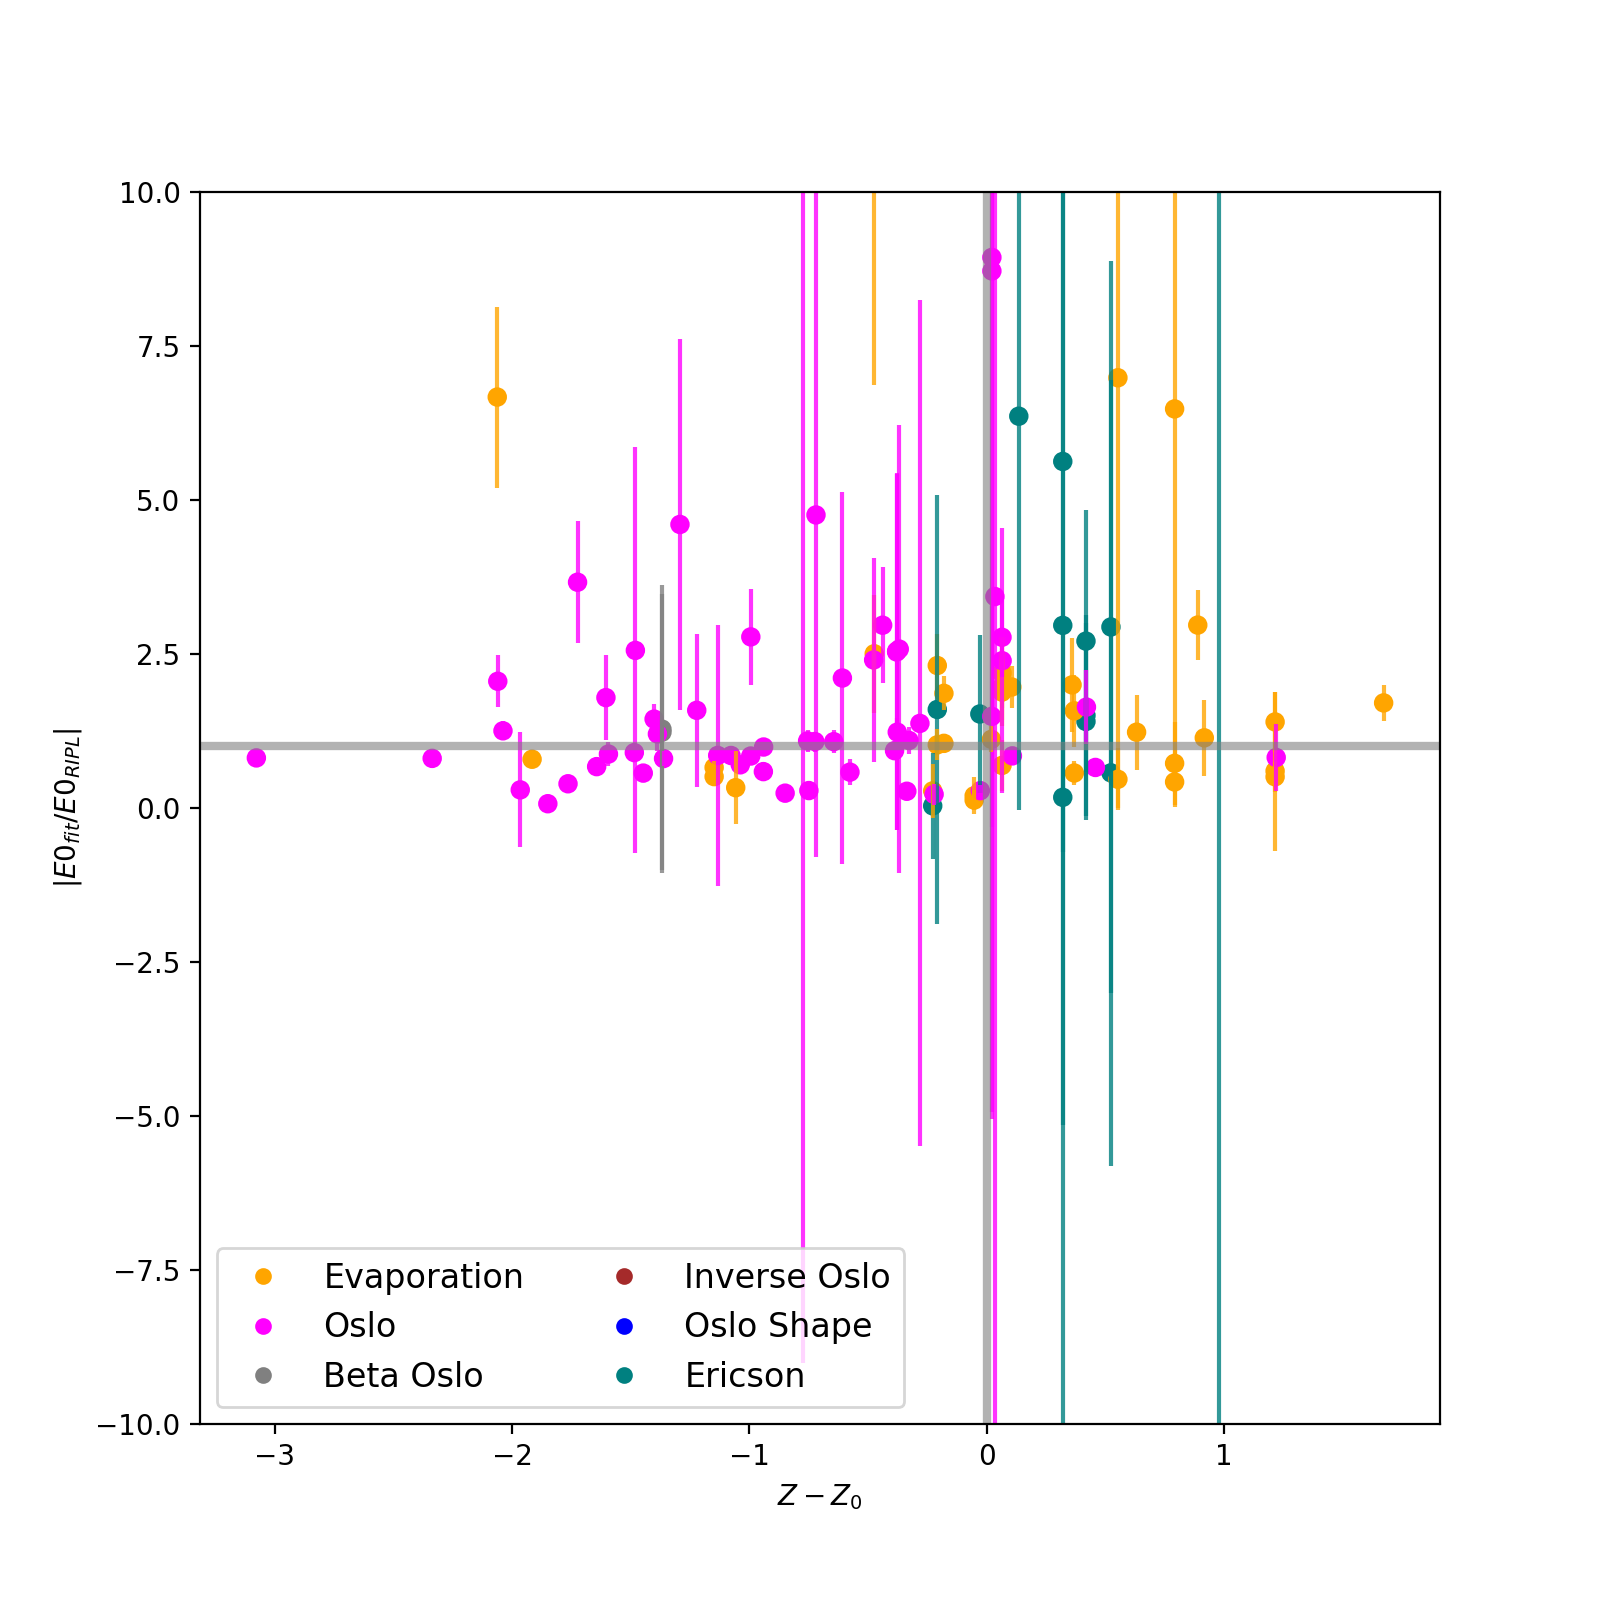

In [86]:
fig,ax = plt.subplots(figsize=(8,8))

ax.errorbar(df_match_egidy['Distance'],np.abs(E0_nominal),E0_uncertainty,fmt='.',color='none',
            ecolor=df_match_egidy['Method'].map(colors),alpha=0.8)

ax.scatter(df_match_egidy['Distance'],np.abs(E0_nominal),marker='o',
            color=df_match_egidy['Method'].map(colors))


plt.axhline(y=1.0,lw=3,color='grey',alpha=0.6)
plt.axvline(x=0.0,lw=3,color='grey',alpha=0.6)
plt.ylim(-10,10)
#plt.yscale('log')
plt.xlabel(r'$Z - Z_0$')
plt.ylabel(r'$|E0_{fit}/E0_{RIPL}|$')

handles = [Line2D([0], [0], linestyle='', marker='.', color=v, label=k, markersize=10) for k, v in colors.items()]
ax.legend(handles=handles, loc='best', ncol=2, fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


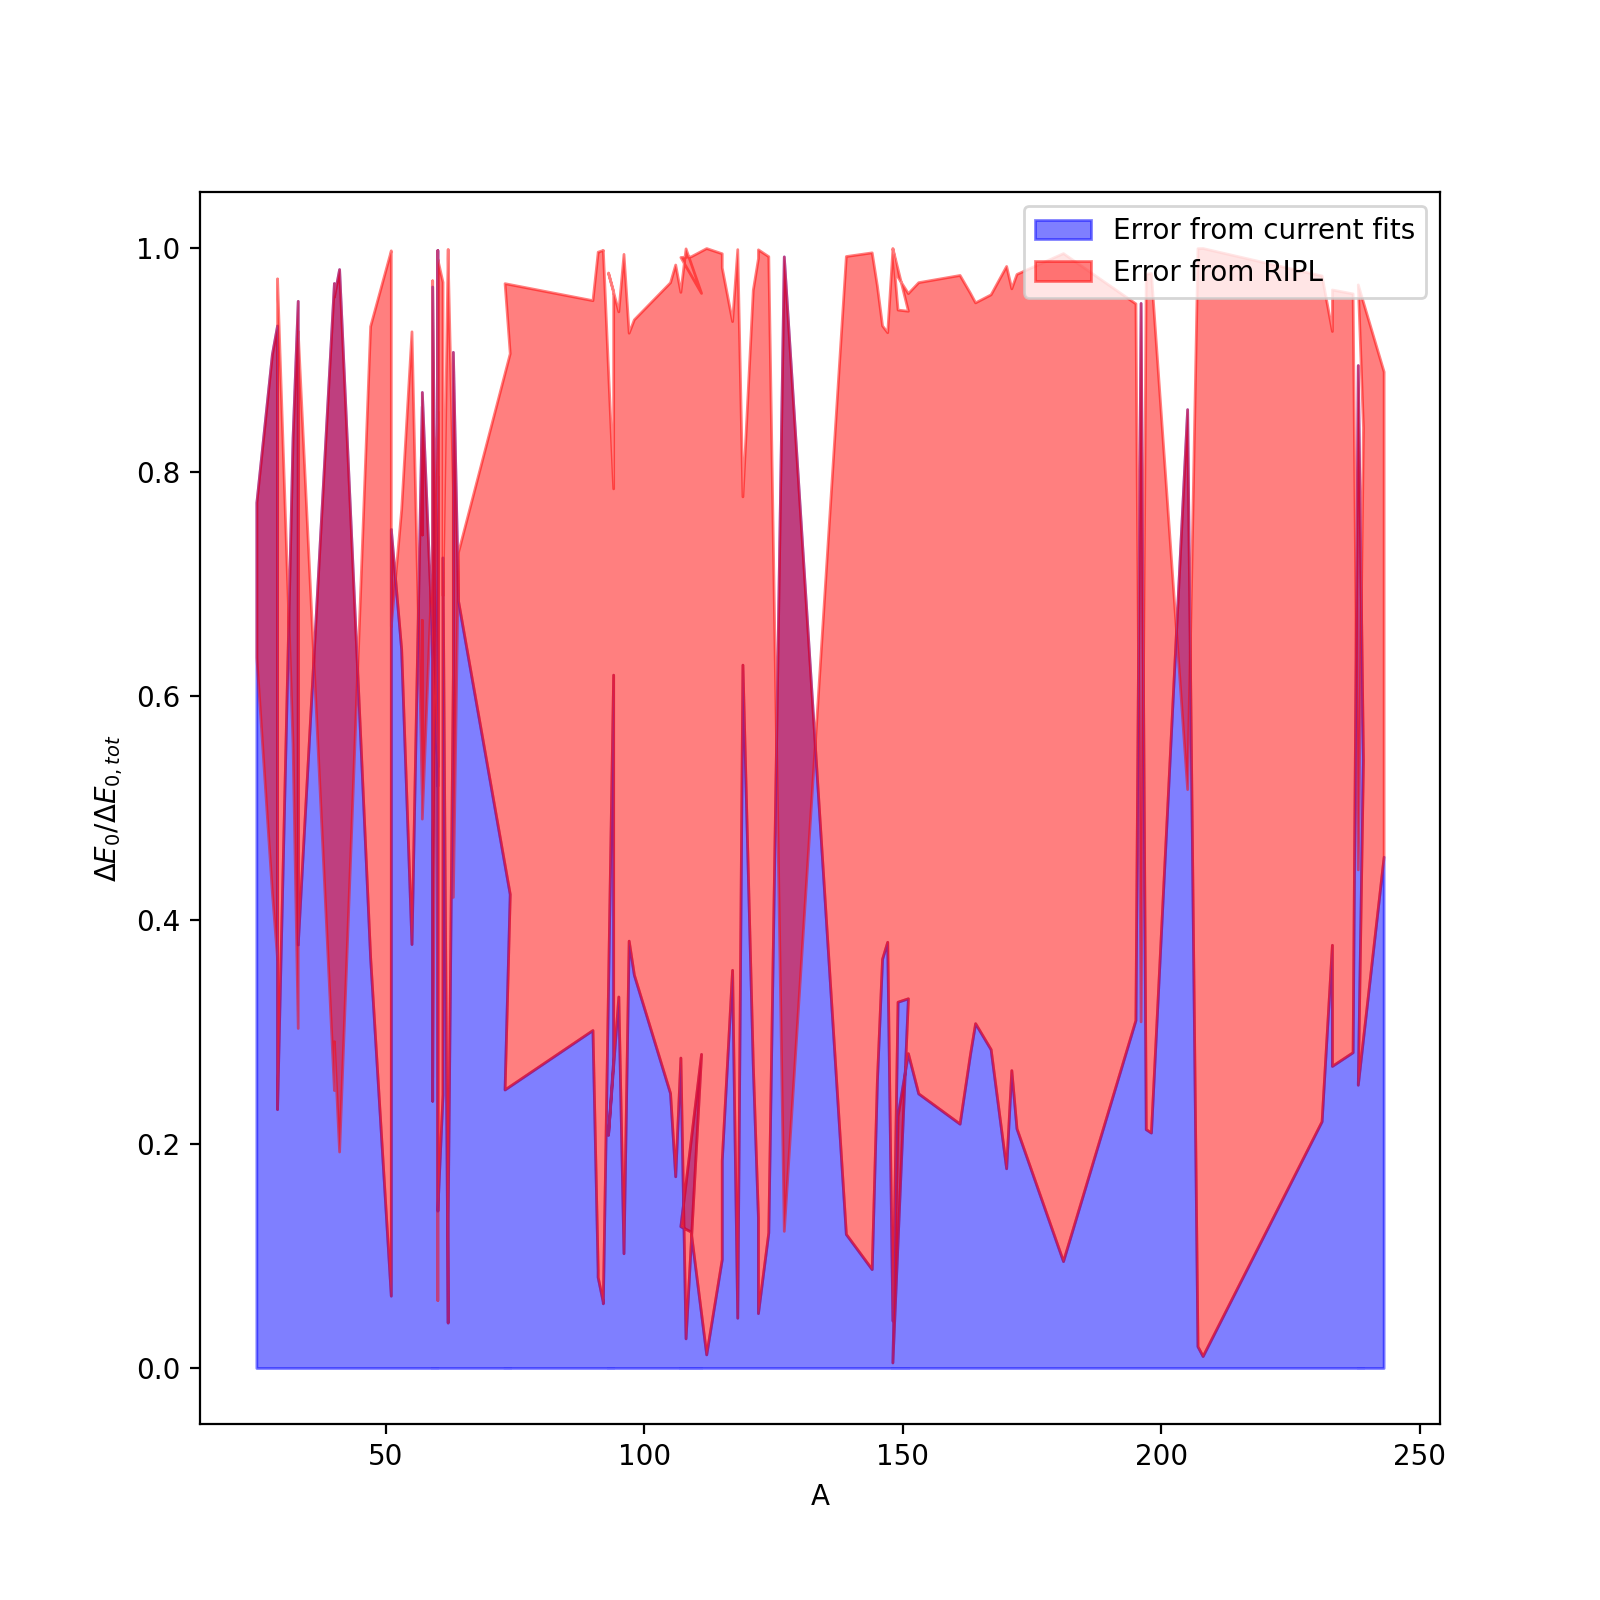

In [51]:
fig,ax = plt.subplots(figsize=(8,8))

E_total_error = np.sqrt(df_match_egidy['dE0']**2 + df_match_egidy['dE0_RIPL']**2)

plt.fill_between(df_match_egidy['A'], 0, df_match_egidy['dE0']/E_total_error, 
                 color='blue', alpha=0.5, label='Error from current fits')

plt.fill_between(df_match_egidy['A'], df_match_egidy['dE0']/E_total_error, df_match_egidy['dE0_RIPL']/E_total_error, 
                 color='red', alpha=0.5, label='Error from RIPL')

# plt.scatter(df_match_egidy['A'],y_total_error,color='m')

# x,y = df_match_egidy['A'].to_list(), y_total_error.to_list()
# for i, txt in enumerate(df_match_egidy['A']):
#     ax.annotate(txt, (x[i], y[i]),fontsize=8)
    
#plt.plot(df_match_egidy['A'], y_total_error, color='black', linestyle='--', label='Total Error')
plt.legend()
plt.ylabel(r'$\Delta E_0/\Delta E_{0,tot}$')
plt.xlabel('A')
#plt.ylim(0,0.2)
plt.show()

<IPython.core.display.Javascript object>


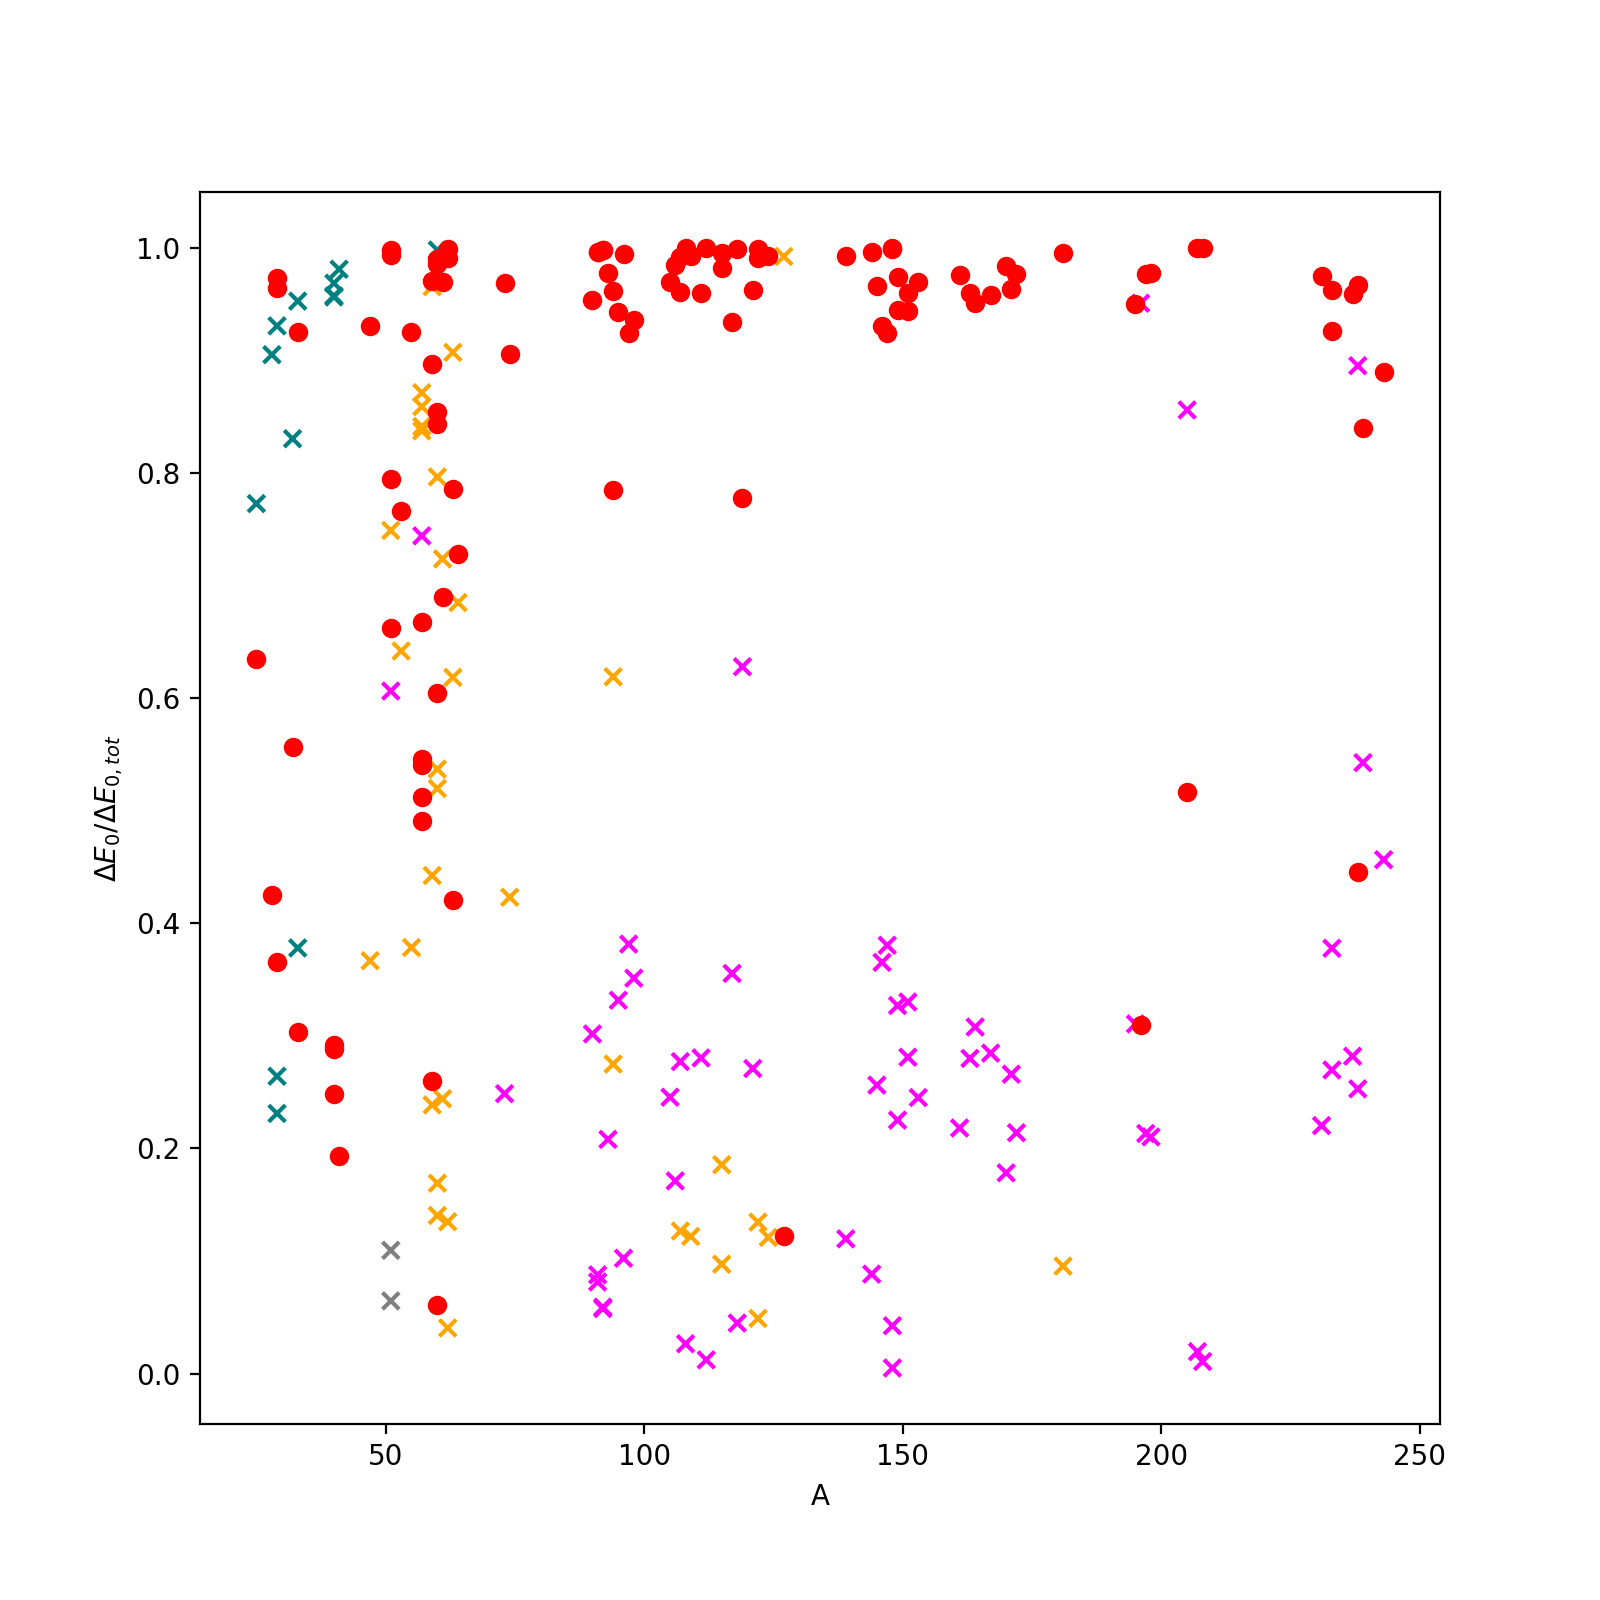

{'Evaporation': 'orange', 'Oslo': 'magenta', 'Beta Oslo': 'grey', 'Inverse Oslo': 'brown', 'Oslo Shape': 'blue', 'Ericson': 'teal'}


In [88]:
fig,ax = plt.subplots(figsize=(8,8))

E_total_error = np.sqrt(df_match_egidy['dE0']**2 + df_match_egidy['dE0_RIPL']**2)

plt.scatter(df_match_egidy['A'],df_match_egidy['dE0']/E_total_error, 
            color=df_match_egidy['Method'].map(colors), marker='x', label='Error from current fits')

plt.scatter(df_match_egidy['A'],df_match_egidy['dE0_RIPL']/E_total_error, 
            color='red', label='Error from RIPL')

# plt.scatter(df_match_egidy['A'],y_total_error,color='m')

# x,y = df_match_egidy['A'].to_list(), y_total_error.to_list()
# for i, txt in enumerate(df_match_egidy['A']):
#     ax.annotate(txt, (x[i], y[i]),fontsize=8)
    
#plt.plot(df_match_egidy['A'], y_total_error, color='black', linestyle='--', label='Total Error')

plt.ylabel(r'$\Delta E_0/\Delta E_{0,tot}$')
plt.xlabel('A')
#plt.ylim(0,0.2)
print(colors)
plt.show()

## Comparison of $\rho_{fit}$ and $\rho_{RIPL}$

In [53]:
ratio_nld_ctm = []
ripl_ctm = []
fit_ctm = []
for i in range(len(df_match_egidy)):
    
    T_ripl = ufloat(df_match_egidy['T_y'][i],df_match_egidy['dT_RIPL'][i])
    E_ripl = ufloat(df_match_egidy['E0_y'][i],df_match_egidy['dE0_RIPL'][i])
    
    T_fit, E_fit = correlated_values([df_match_egidy['T_x'][i], df_match_egidy['E0_x'][i]],cov_mat[i])
    
   # T_fit = ufloat(df_match_egidy['T_x'][i],df_match_egidy['dT'][i])
   # E_fit = ufloat(df_match_egidy['E0_x'][i],df_match_egidy['dE0'][i])
    
    nld_ripl_ctm = u_ctm(5,T_ripl,E_ripl)
    nld_fit_ctm = u_ctm(5,T_fit,E_fit)
    
    ratio_nld_ctm.append(nld_fit_ctm/nld_ripl_ctm)
    
    ripl_ctm.append(nld_ripl_ctm)
    fit_ctm.append(nld_fit_ctm)
    
y_nominal = [nominal_value(val) for val in ratio_nld_ctm]
y_uncertainty = [std_dev(val) for val in ratio_nld_ctm]

<IPython.core.display.Javascript object>


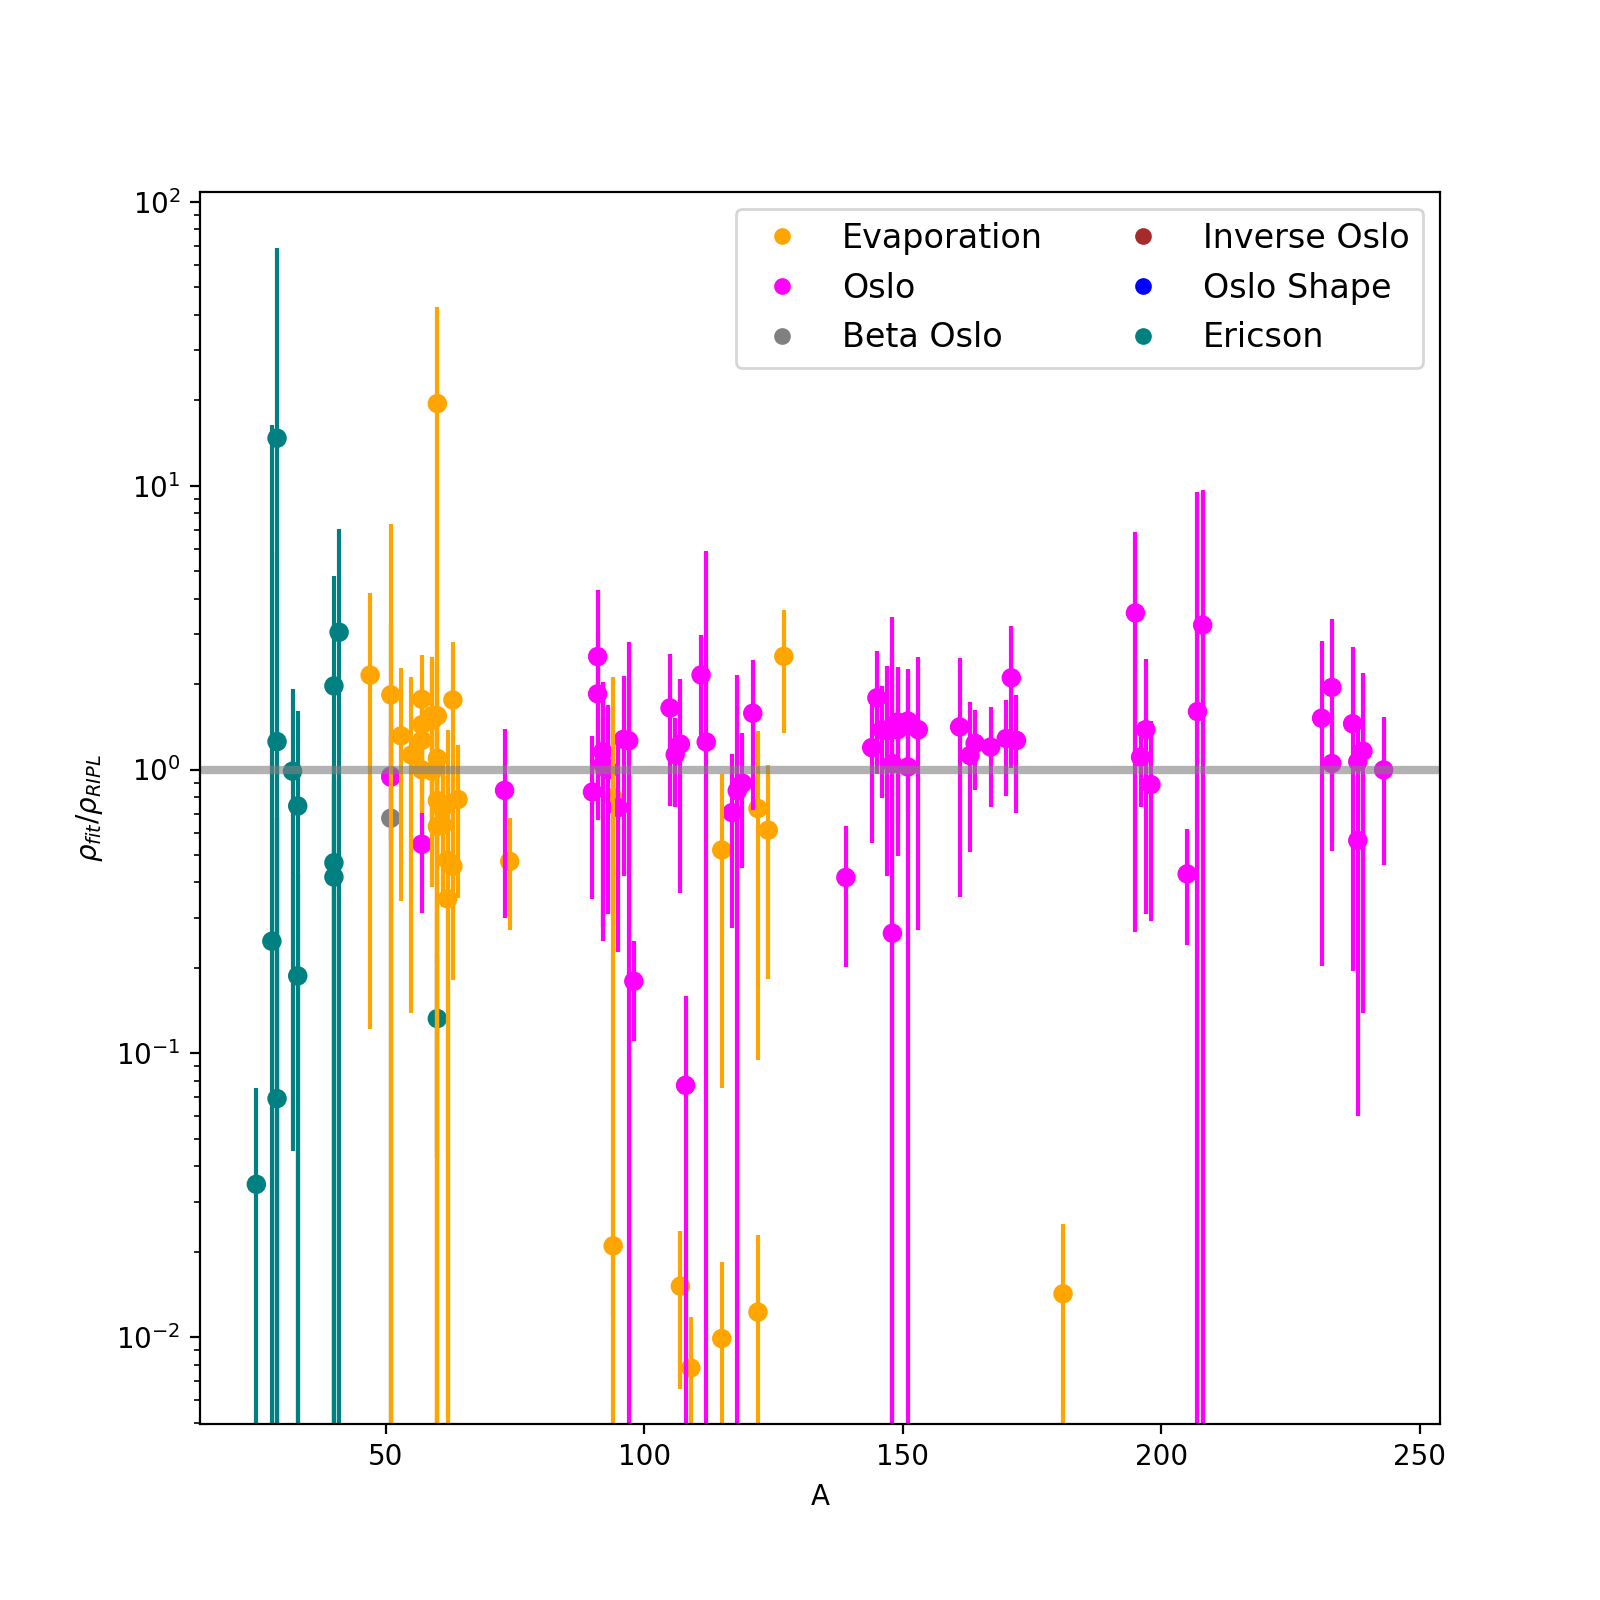

In [54]:
fig,ax = plt.subplots(figsize=(8,8))


ax.errorbar(df_match_egidy['A'],y_nominal,yerr=y_uncertainty,fmt='.',
            color='none',ecolor=df_match_egidy['Method'].map(colors))

ax.scatter(df_match_egidy['A'],y_nominal,marker='o',
            color=df_match_egidy['Method'].map(colors))

plt.axhline(y=1.0,lw=3,color='grey',alpha=0.6)
#plt.axvline(x=0.0,lw=3,color='grey',alpha=0.6)
#plt.ylim(-0.5,4)
plt.yscale('log')
plt.xlabel('A')
plt.ylabel(r'$\rho_{fit}/\rho_{RIPL}$')

handles = [Line2D([0], [0], linestyle='', marker='.', color=v, label=k, markersize=10) for k, v in colors.items()]
ax.legend(handles=handles, loc='best', ncol=2, fontsize=12)

plt.show()

<IPython.core.display.Javascript object>


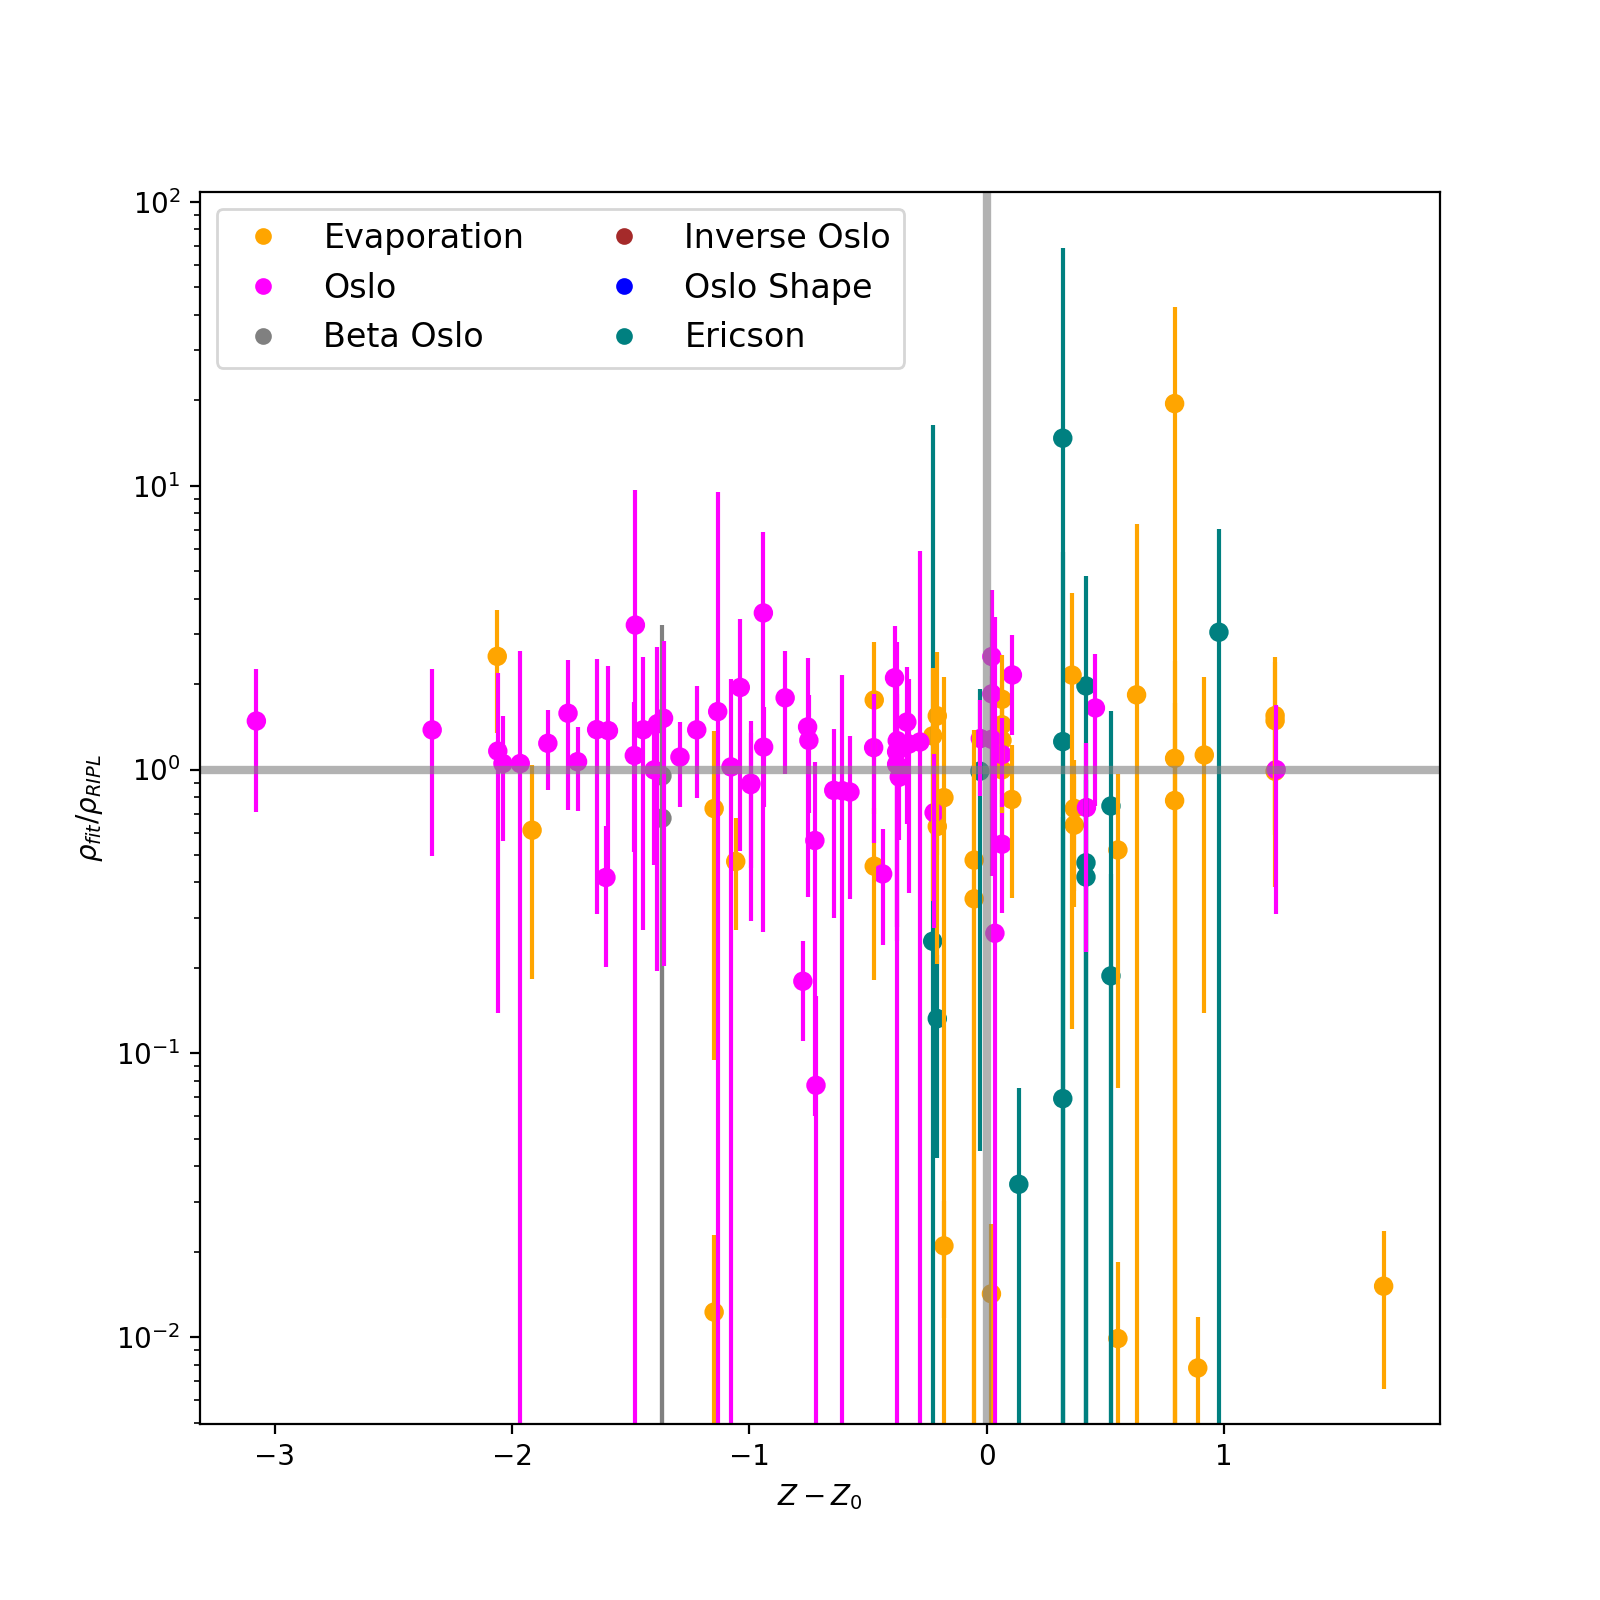

In [89]:
fig,ax = plt.subplots(figsize=(8,8))

ax.errorbar(df_match_egidy['Distance'],y_nominal,yerr=y_uncertainty,fmt='.',
            color='none',ecolor=df_match_egidy['Method'].map(colors))

ax.scatter(df_match_egidy['Distance'],y_nominal,marker='o',
            color=df_match_egidy['Method'].map(colors))

plt.axhline(y=1.0,lw=3,color='grey',alpha=0.6)
plt.axvline(x=0.0,lw=3,color='grey',alpha=0.6)
#plt.ylim(-0.5,4)
plt.yscale('log')
plt.xlabel(r'$Z - Z_0$')
plt.ylabel(r'$\rho_{fit}/\rho_{RIPL}$')

handles = [Line2D([0], [0], linestyle='', marker='.', color=v, label=k, markersize=10) for k, v in colors.items()]
ax.legend(handles=handles, loc='best', ncol=2, fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


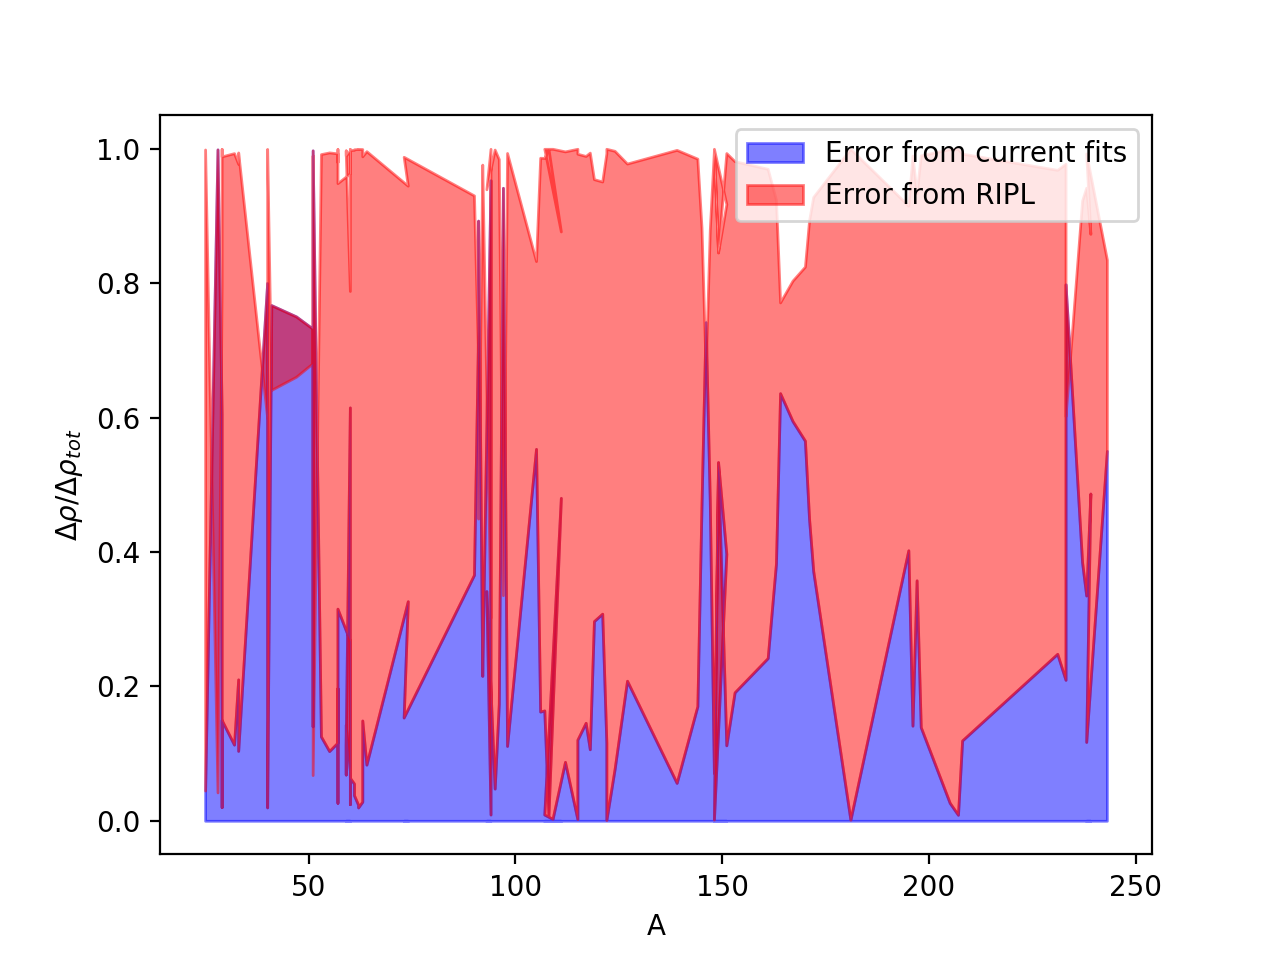

In [74]:
dy_ripl = [std_dev(val) for val in ripl_ctm]
dy_fit = [std_dev(val) for val in fit_ctm]

y_ripl = [nominal_value(val) for val in ripl_ctm]
y_fit = [nominal_value(val) for val in fit_ctm]

dy_ripl = np.array(dy_ripl)
dy_fit = np.array(dy_fit)

y_ripl = np.array(y_ripl)
y_fit = np.array(y_fit)

nld_total_error = np.sqrt(dy_ripl**2 + dy_fit**2)

fig = plt.figure()

plt.fill_between(df_match_egidy['A'], 0, dy_fit/nld_total_error,
                 color='b',alpha=0.5,label='Error from current fits')

plt.fill_between(df_match_egidy['A'],dy_fit/nld_total_error,dy_ripl/nld_total_error, 
                 color='r',alpha=0.5,label='Error from RIPL')


plt.xlabel('A')
plt.ylabel(r'$\Delta \rho / \Delta \rho_{tot}$')
plt.legend()
#plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


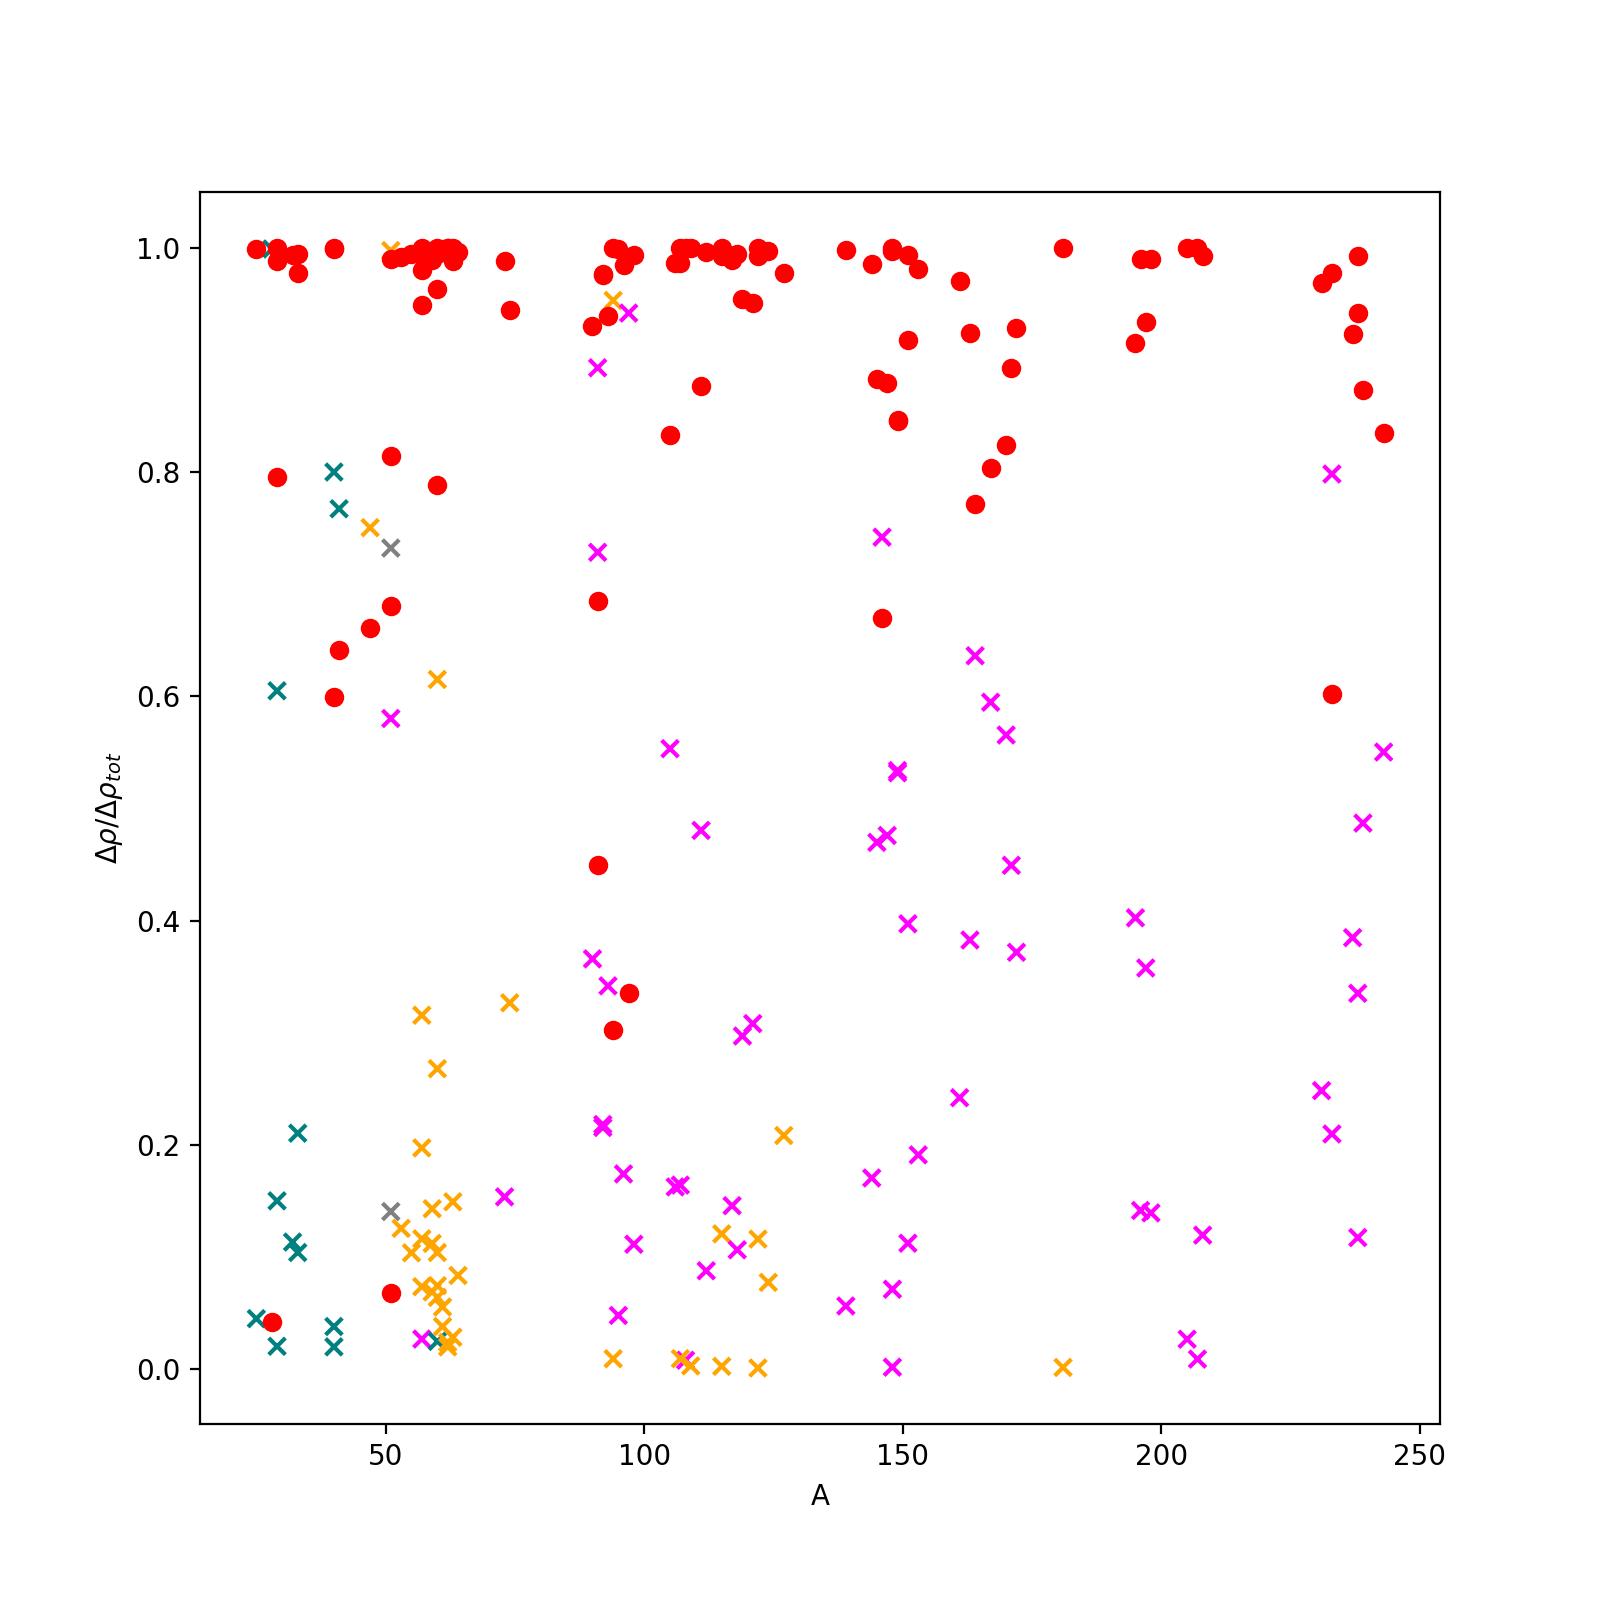

{'Evaporation': 'orange', 'Oslo': 'magenta', 'Beta Oslo': 'grey', 'Inverse Oslo': 'brown', 'Oslo Shape': 'blue', 'Ericson': 'teal'}


In [91]:
fig,ax = plt.subplots(figsize=(8,8))

plt.scatter(df_match_egidy['A'], dy_fit/nld_total_error,
            color=df_match_egidy['Method'].map(colors),marker='x',label='Error from current fits')

plt.scatter(df_match_egidy['A'],dy_ripl/nld_total_error, color='r',label='Error from RIPL')


plt.xlabel('A')
plt.ylabel(r'$\Delta \rho / \Delta \rho_{tot}$')

print(colors)

plt.show()

## Analysis of NLD ($\rho$) at different excitation energies

In [37]:
nld_fit_ctm = []

for i in range(len(df_datafiles_cut)):
    
    
    T_fit = ufloat(df_datafiles_cut['T'][i],df_datafiles_cut['dT'][i])
    E_fit = ufloat(df_datafiles_cut['E0'][i],df_datafiles_cut['dE0'][i])
    
    #nld_ripl_ctm = u_ctm(5,T_ripl,E_ripl)
    fit_ctm = u_ctm(5,T_fit,E_fit)
    
    nld_fit_ctm.append(fit_ctm)
    
    
nld_match_nominal_5 = [nominal_value(val) for val in nld_fit_ctm]
nld_uncertainty_5 = [std_dev(val) for val in nld_fit_ctm]


nld_fit_ctm = []

for i in range(len(df_datafiles_cut)):
    
    
    T_fit = ufloat(df_datafiles_cut['T'][i],df_datafiles_cut['dT'][i])
    E_fit = ufloat(df_datafiles_cut['E0'][i],df_datafiles_cut['dE0'][i])
    
    #nld_ripl_ctm = u_ctm(5,T_ripl,E_ripl)
    fit_ctm = u_ctm(10,T_fit,E_fit)
    
    nld_fit_ctm.append(fit_ctm)
    
    
nld_match_nominal_10 = [nominal_value(val) for val in nld_fit_ctm]
nld_uncertainty_10 = [std_dev(val) for val in nld_fit_ctm]


nld_fit_ctm = []

for i in range(len(df_datafiles_cut)):
    
    
    T_fit = ufloat(df_datafiles_cut['T'][i],df_datafiles_cut['dT'][i])
    E_fit = ufloat(df_datafiles_cut['E0'][i],df_datafiles_cut['dE0'][i])
    
    #nld_ripl_ctm = u_ctm(5,T_ripl,E_ripl)
    fit_ctm = u_ctm(15,T_fit,E_fit)
    
    nld_fit_ctm.append(fit_ctm)
    
    
nld_match_nominal_15 = [nominal_value(val) for val in nld_fit_ctm]
nld_uncertainty_15 = [std_dev(val) for val in nld_fit_ctm]

<IPython.core.display.Javascript object>


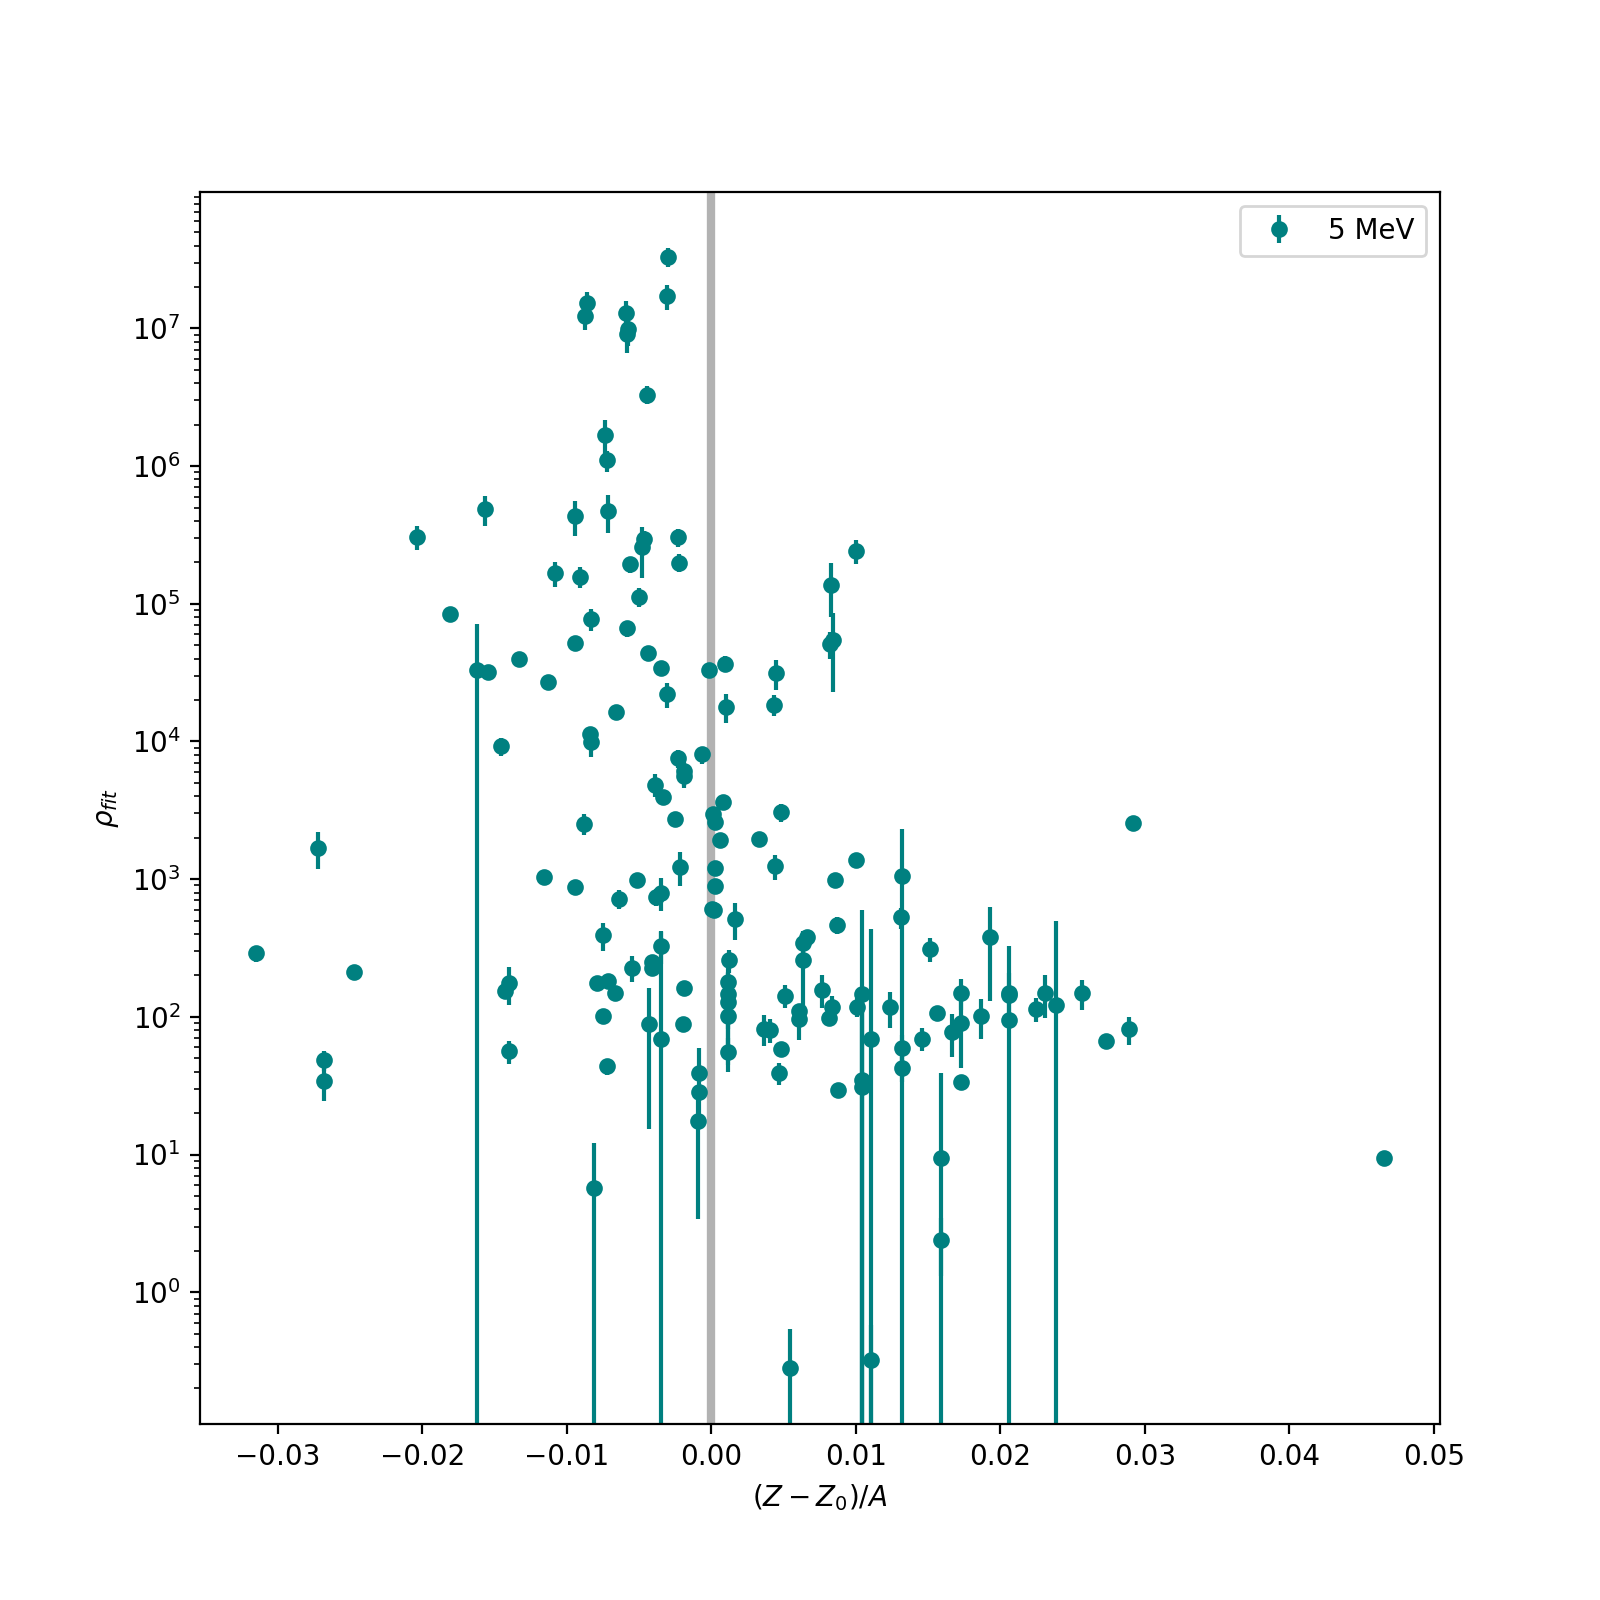

In [38]:
fig,ax = plt.subplots(figsize=(8,8))

plt.errorbar(df_datafiles_cut['Distance']/df_datafiles_cut['A'],nld_match_nominal_5,nld_uncertainty_5,ms=5,color='teal',fmt='o',
              label='5 MeV')

# plt.errorbar(df_datafiles_cut['Distance']/df_datafiles_cut['A'],nld_match_nominal_10,nld_uncertainty_10, fmt = 'o',
#               ms=5,color='m',label = '10 MeV')

# plt.errorbar(df_datafiles_cut['Distance']/df_datafiles_cut['A'],nld_match_nominal_15,nld_uncertainty_15, fmt = 'o',
#               ms=5,color='red',label='15 MeV')

# plt.errorbar(df_datafiles_cut['Distance'],nld_match_nominal_20,nld_uncertainty_20, fmt = 'o',
#               ms=5,color='g',label='20 MeV')

plt.axvline(x=0.0,lw=3,color='grey',alpha=0.6)
#plt.ylim(-0.5,4)
plt.yscale('log')
plt.xlabel(r'$(Z - Z_0)/A$')
plt.ylabel(r'$\rho_{fit}$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


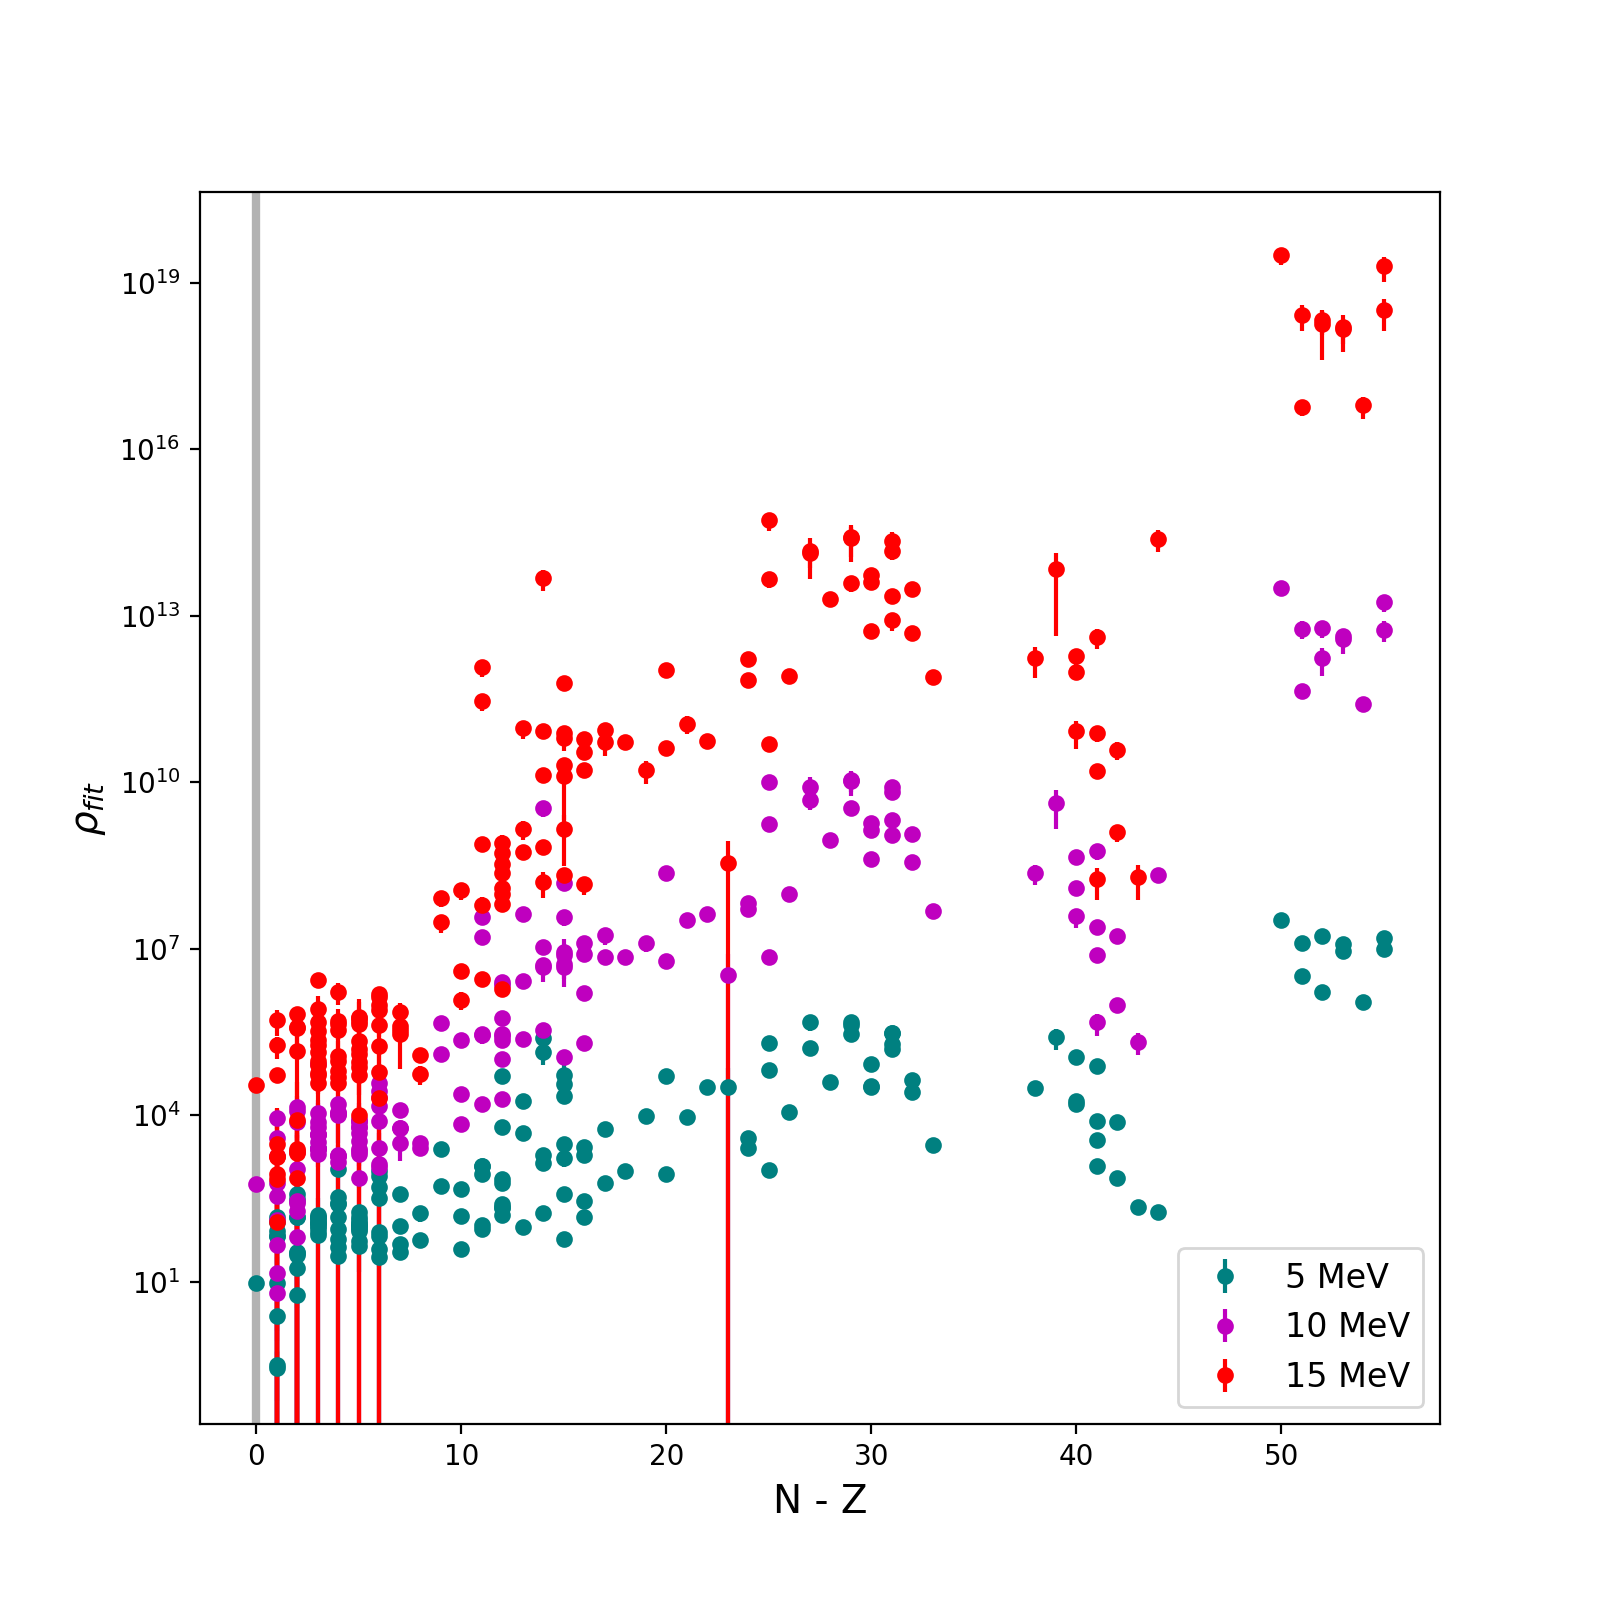

In [36]:
df_datafiles_cut['N'] = df_datafiles_cut['A'] - df_datafiles_cut['Z']

n_rich = df_datafiles_cut['N'] - df_datafiles_cut['Z']

fig,ax = plt.subplots(figsize=(8,8))

plt.errorbar(n_rich,nld_match_nominal_5,nld_uncertainty_5,ms=5,color='teal',fmt='o',
              label='5 MeV')

plt.errorbar(n_rich,nld_match_nominal_10,nld_uncertainty_10, fmt = 'o',
              ms=5,color='m',label = '10 MeV')

plt.errorbar(n_rich,nld_match_nominal_15,nld_uncertainty_15, fmt = 'o',
              ms=5,color='red',label='15 MeV')

# plt.errorbar(df_datafiles_cut['Distance'],nld_match_nominal_20,nld_uncertainty_20, fmt = 'o',
#               ms=5,color='g',label='20 MeV')

plt.axvline(x=0.0,lw=3,color='grey',alpha=0.6)
#plt.ylim(-0.5,4)
plt.yscale('log')
plt.xlabel('N - Z',fontsize=14)
plt.ylabel(r'$\rho_{fit}$',fontsize=14)
plt.legend(fontsize=12)
plt.show()